In [57]:
# -*- coding: utf-8 -*-
"""Fuzzy_Multiplex.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1BkXEtT7GJJkO-krqaVf60GA26U6POPwn
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# ---------------- Synthetic dataset ----------------
np.random.seed()
N = 1000

route_planning = pd.DataFrame({
    'origin_x': np.random.uniform(0, 100, N),
    'origin_y': np.random.uniform(0, 100, N),
    'dest_x': np.random.uniform(0, 100, N),
    'dest_y': np.random.uniform(0, 100, N),
    'traffic_density': np.random.uniform(0, 1, N),
    'road_type': np.random.choice([1, 2, 3], N),
})
route_planning['distance'] = np.sqrt((route_planning['dest_x'] - route_planning['origin_x'])**2 +
                                     (route_planning['dest_y'] - route_planning['origin_y'])**2)
speed_base = {1:50, 2:40, 3:30}
route_planning['speed'] = route_planning['road_type'].map(speed_base) * np.random.uniform(0.8,1.2,N)
route_planning['travel_time'] = (route_planning['distance']/route_planning['speed'])*60*\
                                (1+route_planning['traffic_density']*np.random.uniform(0.1,0.5,N))

vehicle_assignment = pd.DataFrame({
    'vehicle_capacity': np.random.randint(50,200,N),
    'battery_level': np.random.uniform(0.3,1.0,N),

    'delivery_size': np.random.randint(5,50,N),
    'vehicle_type': np.random.choice([1,2],N),
    'speed_factor': np.random.uniform(0.9,1.1,N),
})
vehicle_assignment['assigned_speed'] = route_planning['speed']*vehicle_assignment['speed_factor']
vehicle_assignment['load_utilization'] = vehicle_assignment['delivery_size']/vehicle_assignment['vehicle_capacity']

time_scheduling = pd.DataFrame({
    'requested_time': np.random.randint(8,20,N),
    'delivery_priority': np.random.randint(1,5,N),
    'customer_patience': np.random.uniform(0,1,N),
})
time_scheduling['delay_probability'] = np.clip(
    (route_planning['travel_time']/60)*(1+vehicle_assignment['load_utilization']*0.5)*np.random.uniform(0.8,1.2,N),
    0,1
)

dynamic_rerouting = pd.DataFrame({
    'current_x': np.random.uniform(0,100,N),
    'current_y': np.random.uniform(0,100,N),
    'traffic_updates': np.random.uniform(0,1,N),
    'new_delivery_requests': np.random.randint(0,3,N),
    'vehicle_status': np.random.choice([0,1],N),
    'weather': np.random.choice([0,1],N),
})
dynamic_rerouting['congestion_score'] = dynamic_rerouting['traffic_updates'] + \
                                       dynamic_rerouting['new_delivery_requests']*0.5 + \
                                       dynamic_rerouting['weather']*0.5 + \
                                       (route_planning['travel_time']/route_planning['travel_time'].max())*0.5

# ---------------- Combine and normalize ----------------
datasets = [route_planning, vehicle_assignment, time_scheduling, dynamic_rerouting]
dataset_dims = [df.shape[1] for df in datasets]
max_dim = max(dataset_dims)
padded_data = [df.values for df in datasets]

DATA_MATRIX = np.hstack(padded_data)
DATA_MATRIX = (DATA_MATRIX - DATA_MATRIX.min(axis=0)) / (np.ptp(DATA_MATRIX, axis=0)+1e-8)
def generate_targets_per_node(DATA_MATRIX, candidate_dims, D_graph):
    """
    Generate target vectors for each node with its own candidate dimension.

    Parameters:
    - DATA_MATRIX: normalized data array
    - candidate_dims: list of ints, length = D_graph, each specifying the target vector size per node
    - D_graph: number of graph nodes

    Returns:
    - List of dicts: each dict contains the node's target vector under key 'target'
    """
    targets = []
    for node_idx in range(D_graph):
        row = DATA_MATRIX[node_idx % len(DATA_MATRIX)]
        dim = candidate_dims[node_idx]  # get the dim for this node
        if len(row) >= dim:
            sampled = row[:dim]
        else:
            sampled = np.pad(row, (0, dim - len(row)), constant_values=0.5)
        targets.append({'target': sampled})
    return targets

# Example: each node has its own target dimension
candidate_dims = [4, 3, 2, 3]  # D_graph=5
D_graph = len(candidate_dims)

synthetic_targets = generate_targets_per_node(DATA_MATRIX, candidate_dims, D_graph)

# check
for i, t in enumerate(synthetic_targets):
    print(f"Node {i} target size: {len(t['target'])}")

class MetricsEvaluator:
    def __init__(self, data_matrix):
        self.data_matrix = data_matrix
        self.num_features = data_matrix.shape[1]
        self.W0, self.T0, self.U0 = 15.0, 100.0, 10.0
        self.P0 = 10.0  # baseline for patience

    def compute_node_metrics(self, node_idx, y=None, node_size=None):
        """
        node_size: number of features in this node (optional)
        """
        # Default to 4 features if node_size not given
        node_size = node_size or 4

        # Slice only the node's columns
        start_col = sum(self.data_matrix.shape[1] // self.data_matrix.shape[0] for _ in range(node_idx))  # optional
        node_cols = slice(start_col, start_col + node_size)
        node_data = self.data_matrix[:, node_cols]

        # Compute signals safely for available features
        signals_full = node_data.mean(axis=0)
        signals = np.zeros(4)
        for i in range(min(4, len(signals_full))):
            signals[i] = signals_full[i]
        # signals[i] = 0 for missing features

        # Handle y: use only available entries
        if y is None:
            y = np.zeros(3)
        else:
            y = np.array(y)
            if len(y) < 3:
                y = np.pad(y, (0, 3-len(y)), constant_values=0.5)
            else:
                y = y[:3]

        wait = np.clip(self.W0*(1 + 1.2*signals[0] + 1*y[0]), 0, 150)
        throughput = np.clip(self.T0*(1 + 1.1*signals[1] + 0.6*y[1] - 0.4*signals[0]), 0, 150)
        util = np.clip(self.U0 + 1.2*signals[2] + 1.5*y[2], 0, 150)
        patience = np.clip(self.P0*(1 + 0.5*signals[3] + 0.5*y[0]), 0, 200)

        score = -wait + throughput + util + patience

        return {'wait': wait, 'throughput': throughput, 'util': util,
                'patience': patience, 'score': score}

Node 0 target size: 4
Node 1 target size: 3
Node 2 target size: 2
Node 3 target size: 3


In [58]:
DATA_MATRIX.shape

(1000, 27)

In [59]:
import numpy as np

class MetricsEvaluator:
    def __init__(self, data_matrix):
        self.data_matrix = data_matrix
        self.num_features = data_matrix.shape[1]
        self.W0, self.T0, self.U0 = 15.0, 100.0, 10.0
        self.P0 = 10.0  # baseline for patience

    def compute_node_metrics(self, node_idx, y=None, node_size=None):
        """
        node_size: number of features in this node (optional)
        """
        # Default to 4 features if node_size not given
        node_size = node_size or 4

        # Slice only the node's columns
        start_col = sum(self.data_matrix.shape[1] // self.data_matrix.shape[0] for _ in range(node_idx))  # optional
        node_cols = slice(start_col, start_col + node_size)
        node_data = self.data_matrix[:, node_cols]

        # Compute signals safely for available features
        signals_full = node_data.mean(axis=0)
        signals = np.zeros(4)
        for i in range(min(4, len(signals_full))):
            signals[i] = signals_full[i]

        # Handle y: use only available entries
        if y is None:
            y = np.zeros(3)
        else:
            y = np.array(y)
            if len(y) < 3:
                y = np.pad(y, (0, 3-len(y)), constant_values=0.5)
            else:
                y = y[:3]

        # Columns assumed: [travel_time, load_util, priority, delay_prob, congestion]
        travel_time = self.data_matrix[node_idx][0]
        load_util = self.data_matrix[node_idx][1]
        priority = self.data_matrix[node_idx][2]
        delay_prob = self.data_matrix[node_idx][3]
        congestion = self.data_matrix[node_idx][4]

        # --- Inexact GA-based computation ---
        # Simple internal GA to perturb metrics slightly
        def ga_metric(base, population=5, generations=10, mutation=0.1):
            pop = base + 0.1 * np.random.randn(population)
            for _ in range(generations):
                fitness = pop  # identity as placeholder; higher = better
                top_idx = np.argmax(fitness)
                best = pop[top_idx]
                # mutate all slightly around best
                pop = best + mutation * np.random.randn(population)
            return best

        wait = 1 / (1 + ga_metric(travel_time))
        throughput = ga_metric(load_util)
        util = ga_metric(priority * (1 - delay_prob))
        patience = 1 / (1 + ga_metric(congestion))

        score = -wait + throughput + util + patience

        return {'wait': wait, 'throughput': throughput, 'util': util,
                'patience': patience, 'score': score}



--- Generation 0 Metrics ---
Node 0 | wait: 0.42 | throughput: 1.59 | util: 1.22 | patience: 0.39 | score: 3.62
Node 1 | wait: 0.35 | throughput: 1.68 | util: 1.31 | patience: 0.35 | score: 3.69
Node 2 | wait: 0.50 | throughput: 1.96 | util: 1.48 | patience: 0.32 | score: 4.25
Node 3 | wait: 0.33 | throughput: 1.65 | util: 2.23 | patience: 0.48 | score: 4.69

--- Generation 0 Node Contributions ---
Node 0: Contribution = 3.9532
Node 1: Contribution = 4.2018
Node 2: Contribution = 4.7805
Node 3: Contribution = 4.4359
Outer Score (capped): -428.375

--- Generation 1 Metrics ---
Node 0 | wait: 0.41 | throughput: 1.42 | util: 0.85 | patience: 0.35 | score: 3.04
Node 1 | wait: 0.32 | throughput: 2.15 | util: 1.35 | patience: 0.35 | score: 4.17
Node 2 | wait: 0.51 | throughput: 2.15 | util: 1.77 | patience: 0.32 | score: 4.75
Node 3 | wait: 0.31 | throughput: 1.08 | util: 1.16 | patience: 0.51 | score: 3.06

--- Generation 1 Node Contributions ---
Node 0: Contribution = 4.7480
Node 1: Contr

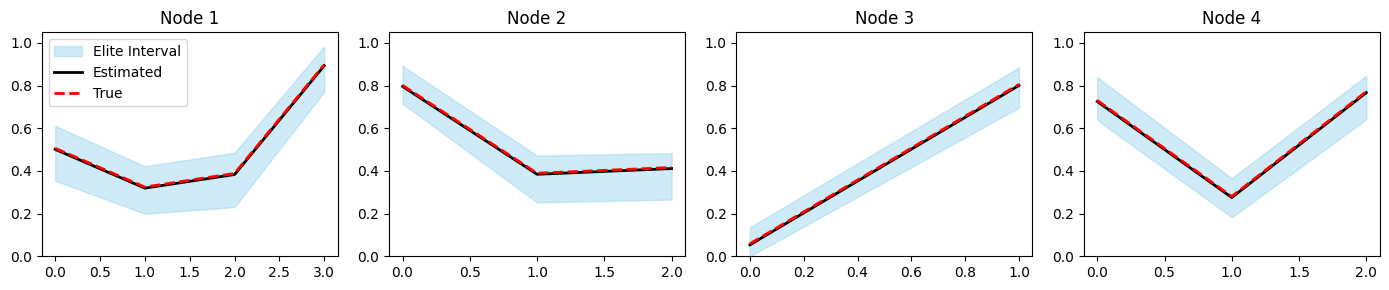

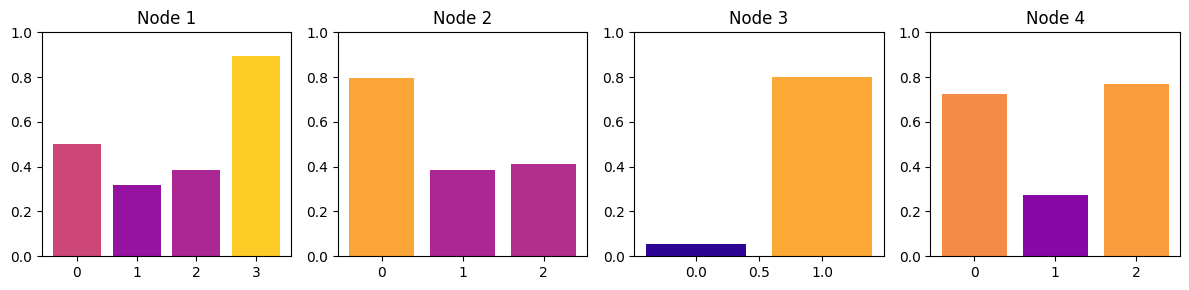

/tmp/ipykernel_7967/1084314867.py:638: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


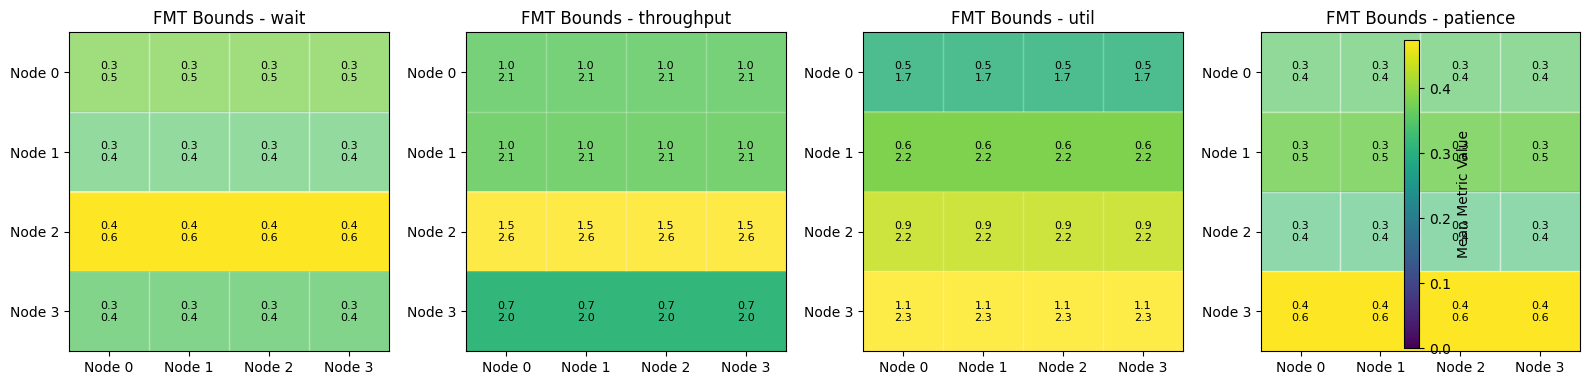

/tmp/ipykernel_7967/1084314867.py:570: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


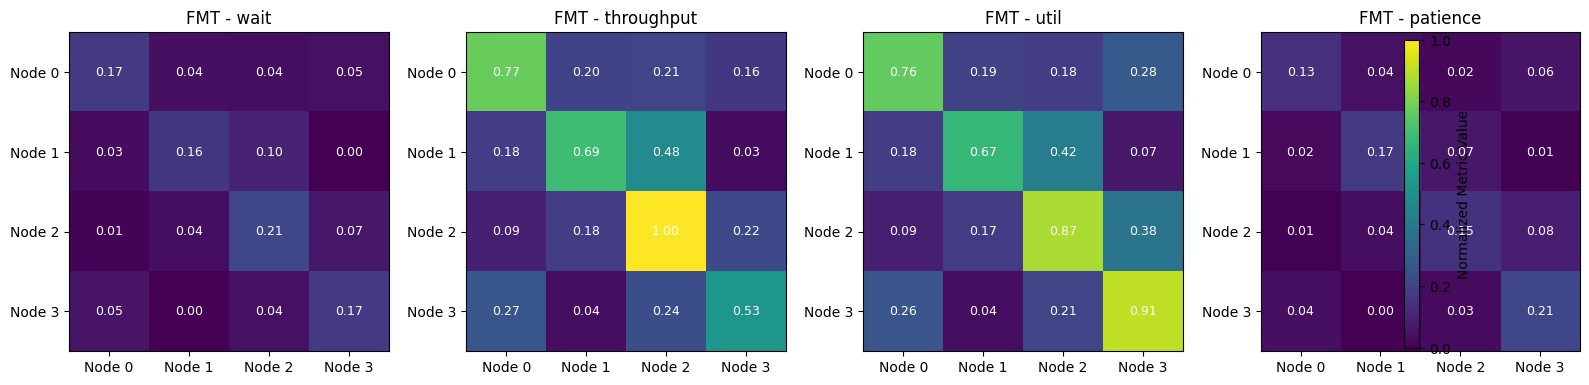

/tmp/ipykernel_7967/1084314867.py:702: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


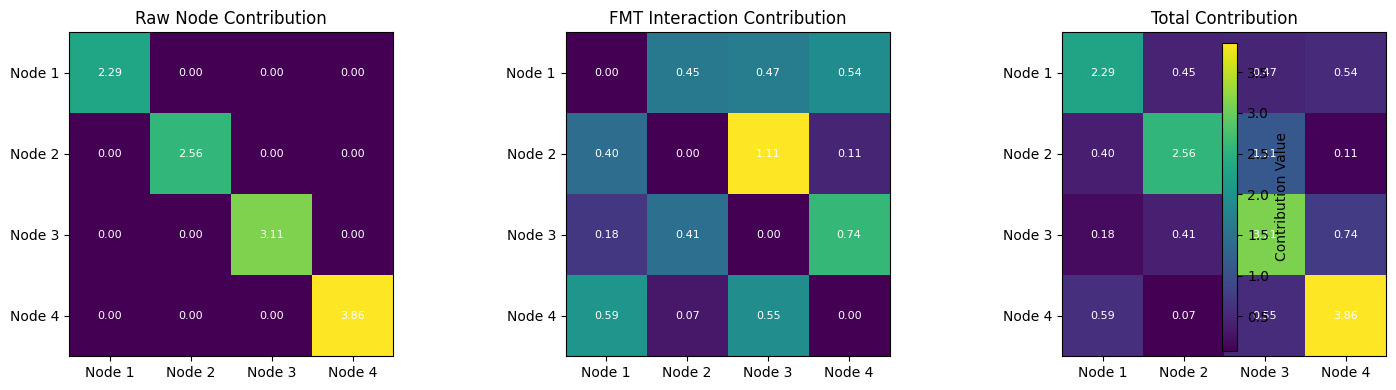

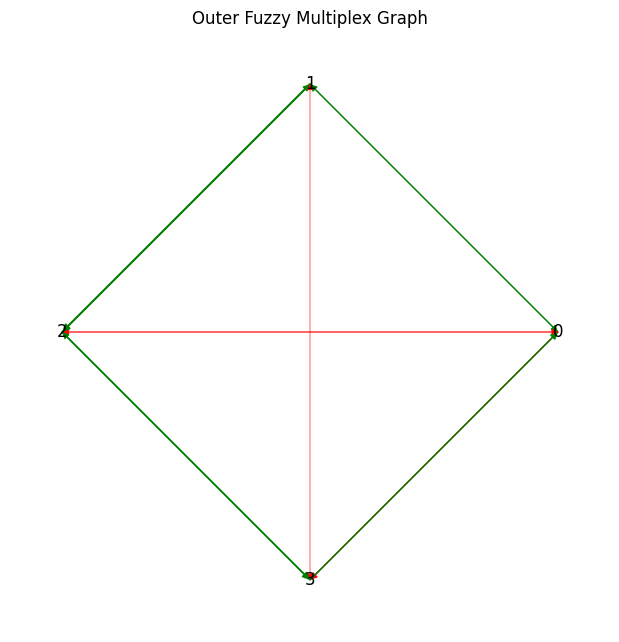

Node 0 -> Node 1: [0.481, 0.577, 0.508, 0.516]
Node 0 -> Node 2: [0.493, 0.554, 0.507, 0.502]
Node 0 -> Node 3: [0.506, 0.531, 0.477, 0.545]
Node 1 -> Node 0: [0.519, 0.531, 0.514, 0.535]
Node 1 -> Node 2: [0.496, 0.455, 0.517, 0.477]
Node 1 -> Node 3: [0.435, 0.498, 0.543, 0.459]
Node 2 -> Node 0: [0.480, 0.501, 0.505, 0.520]
Node 2 -> Node 1: [0.517, 0.490, 0.463, 0.509]
Node 2 -> Node 3: [0.448, 0.497, 0.503, 0.484]
Node 3 -> Node 0: [0.487, 0.547, 0.464, 0.479]
Node 3 -> Node 1: [0.515, 0.508, 0.517, 0.483]
Node 3 -> Node 2: [0.539, 0.448, 0.532, 0.580]
Tensor shape: (4, 4, 4) 
 [[[0.         0.         0.         0.        ]
  [0.48105603 0.57722418 0.50818126 0.51560628]
  [0.493116   0.55425058 0.50650888 0.50155987]
  [0.50619128 0.5307626  0.47681634 0.54512793]]

 [[0.5190859  0.5308007  0.51409209 0.53528497]
  [0.         0.         0.         0.        ]
  [0.49577751 0.45531598 0.51682141 0.47732176]
  [0.43533417 0.49775324 0.5434717  0.45948194]]

 [[0.47989413 0.500887

/tmp/ipykernel_7967/1084314867.py:735: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(fmt_mean, inter_vec)


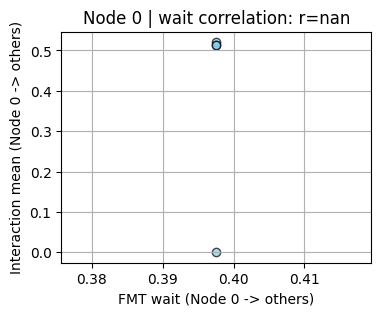

Node 0 | throughput: r = nan, p = nan


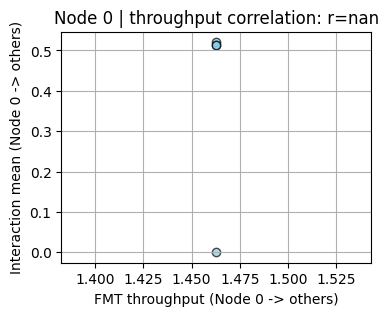

Node 0 | util: r = nan, p = nan


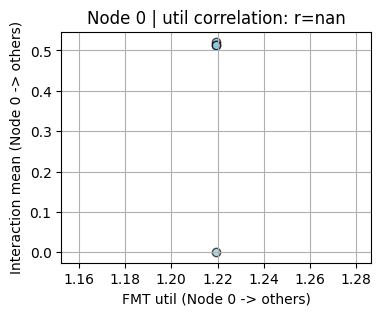

Node 0 | patience: r = nan, p = nan


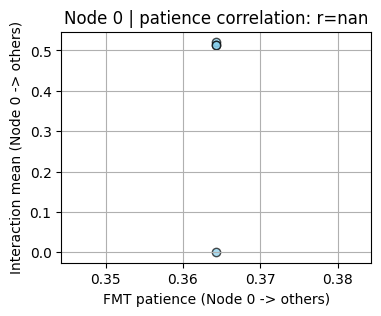

Node 1 | wait: r = nan, p = nan


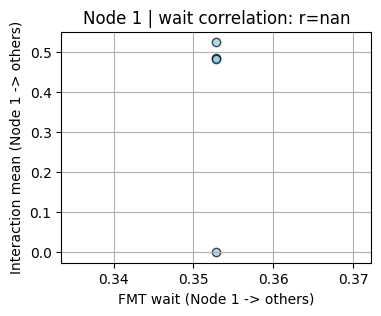

Node 1 | throughput: r = nan, p = nan


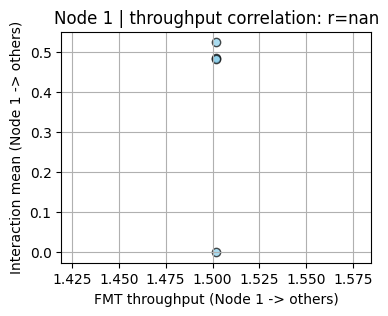

Node 1 | util: r = nan, p = nan


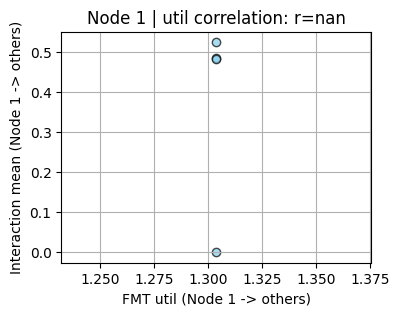

Node 1 | patience: r = nan, p = nan


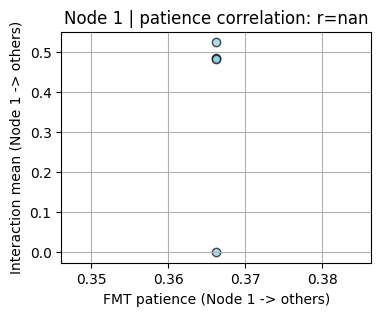

Node 2 | wait: r = nan, p = nan


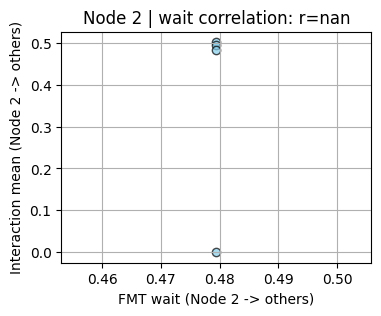

Node 2 | throughput: r = nan, p = nan


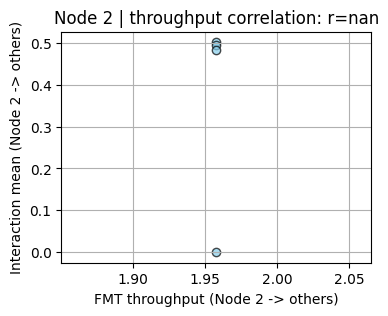

Node 2 | util: r = nan, p = nan


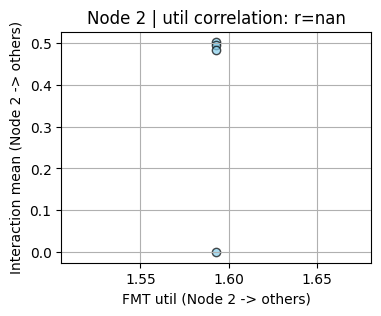

Node 2 | patience: r = nan, p = nan


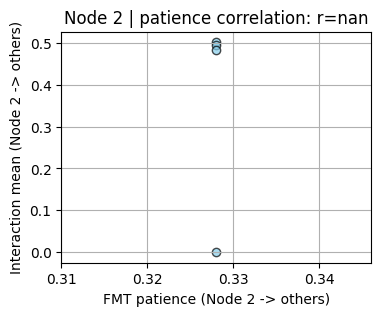

Node 3 | wait: r = nan, p = nan


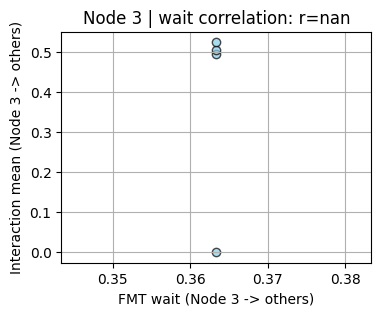

Node 3 | throughput: r = nan, p = nan


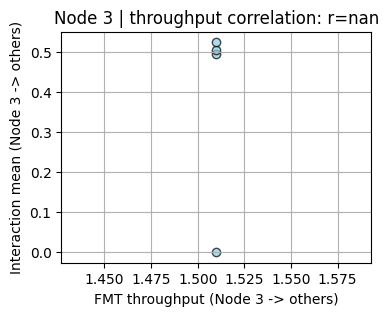

Node 3 | util: r = nan, p = nan


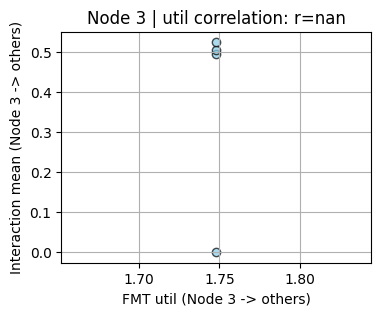

Node 3 | patience: r = nan, p = nan


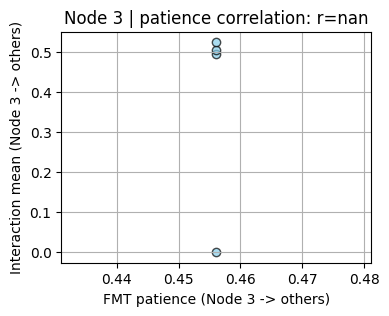

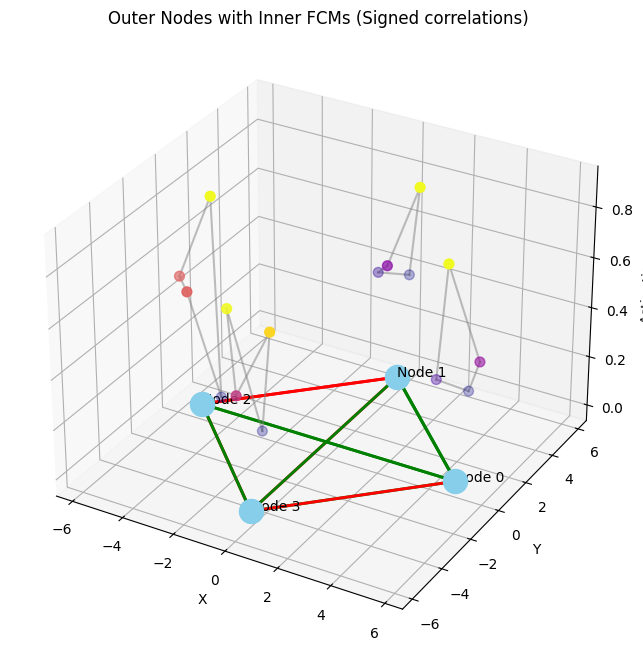

Node 0 Metrics: {'wait': 0.3642093203064413, 'throughput': 1.5904570382036685, 'util': 1.4134634653847138, 'patience': 0.46344287884264185, 'score': 3.103154062124583}
Node 0 Activations: [0.50135136 0.31953087 0.38339808 0.89362756]
Node 0 MI Score: 39.71296758602149
Node 1 Metrics: {'wait': 0.449076760921465, 'throughput': 1.3914208039601368, 'util': 1.432865502585268, 'patience': 0.41522935544746686, 'score': 2.790438901071407}
Node 1 Activations: [0.79637593 0.38445553 0.41129673 0.5       ]
Node 1 MI Score: 39.71296758602149
Node 2 Metrics: {'wait': 0.4749063106339327, 'throughput': 1.729692693967405, 'util': 1.0410297478716402, 'patience': 0.3775751353339365, 'score': 2.673391266539049}
Node 2 Activations: [0.05361747 0.80109441 0.5        0.5       ]
Node 2 MI Score: 39.71296758602149
Node 3 Metrics: {'wait': 0.34418531658650514, 'throughput': 1.4164758394339731, 'util': 1.540015719809015, 'patience': 0.2942772369095611, 'score': 2.9065834795660437}
Node 3 Activations: [0.725663

In [61]:


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ---------------- CONFIG ----------------nsion
candidate_dims = [4, 3, 2, 3]  # D_graph=5
D_graph = len(candidate_dims)

inner_archive_size = 80
inner_offspring = 40
outer_archive_size = 40
outer_offspring = 40
inner_iters_per_outer = 50
outer_generations = 10
outer_cost_limit = 10000
inner_learning = 0.1
gamma_interlayer = 1
top_k = 263
np.random.seed()




class InterLayer:
    def __init__(self, D_graph, max_inner_dim, inter_dim=None, edge_threshold=0.02, gamma=1.0, seed=42):
        np.random.seed(seed)
        self.D_graph = D_graph
        self.max_input = 2 * max_inner_dim
        self.edge_threshold = edge_threshold
        self.gamma = gamma
        self.inter_dim = inter_dim if inter_dim is not None else max_inner_dim

        # Initialize weights proportional to synthetic correlation between nodes
        self.weights = {}
        self.bias = {}
        for i in range(D_graph):
            for j in range(D_graph):
                if i != j:
                    # small random + slight bias towards correlation
                    w_init = np.random.uniform(-0.1, 0.1, (self.inter_dim, self.max_input))
                    self.weights[(i,j)] = w_init
                    self.bias[(i,j)] = np.zeros(self.inter_dim)

    def compute_edge_activation(self, i, j, nested_reps):
        concat = np.concatenate([nested_reps[i], nested_reps[j]])
        concat = np.pad(concat, (0, max(0, self.max_input - len(concat))))[:self.max_input]

        # Normalize input to improve correlation
        concat = (concat - np.mean(concat)) / (np.std(concat) + 1e-12)

        # Compute activation
        v = self.weights[(i,j)].dot(concat) + self.bias[(i,j)]

        # Scale by correlation strength with input signals
        input_strength = np.clip(np.mean(np.abs(concat)), 0, 1)
        v = v * input_strength

        return 1 / (1 + np.exp(-v))

    def build_activations(self, Gmat, nested_reps):
        acts = {}
        for i in range(self.D_graph):
            for j in range(self.D_graph):
                if i == j:
                    continue
                if abs(Gmat[i,j]) > self.edge_threshold:
                    acts[(i,j)] = self.compute_edge_activation(i, j, nested_reps)
        return acts

    @staticmethod
    def pairwise_squared_corr(acts):
        if len(acts) < 2:
            return 0.0
        A = np.stack(list(acts.values()))
        A_centered = A - A.mean(axis=1, keepdims=True)
        stds = np.sqrt(np.sum(A_centered**2, axis=1) / (A.shape[1]-1) + 1e-12)
        cov = A_centered @ A_centered.T / (A.shape[1]-1)
        corr = cov / (np.outer(stds, stds) + 1e-12)
        np.fill_diagonal(corr, 0)
        return float((corr**2).sum())

    def mi_for_graph(self, Gmat, nested_reps):
        acts = self.build_activations(Gmat, nested_reps)
        if not acts:
            return 0.0
        return self.gamma * self.pairwise_squared_corr(acts)

    def correlate_shrink_interlayer(self, fmt_bounds=None, interaction_tensor=None, metrics_keys=None, verbose=True):
        """
        Compute Pearson correlation per node & metric between:
            - shrink factor (adaptive FMT)
            - mean outgoing inter-layer activations
        Returns: {node_idx: {metric: {'r':..., 'p':...}}}
        """
        from scipy.stats import pearsonr

        if metrics_keys is None:
            metrics_keys = ['wait','throughput','util','patience']

        D = self.D_graph

        # 1. Compute FMT bounds if not given
        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_bounds_adaptive(top_k=top_k)

        # 2. Get inter-layer activations if not provided
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        inter_mean = interaction_tensor.mean(axis=2)  # (D,D)
        shrink_factors = self.compute_fmt_shrink_factor(fmt_bounds, metrics_keys)  # (D, num_metrics)

        correlations = {}

        for i in range(D):
            correlations[i] = {}
            for k, key in enumerate(metrics_keys):
                # FMT shrink for node i (broadcasted across outgoing edges)
                shrink_vec = shrink_factors[i, k] * np.ones(D)
                # Outgoing inter-layer activations from node i
                inter_vec = inter_mean[i, :]
                # Remove self-loop
                mask = np.arange(D) != i
                shrink_vec = shrink_vec[mask]
                inter_vec = inter_vec[mask]

                # Compute Pearson correlation
                if np.std(inter_vec) > 1e-8:  # valid correlation
                    r, p = pearsonr(shrink_vec, inter_vec)
                else:
                    r, p = 0.0, 1.0  # no variability

                correlations[i][key] = {'r': r, 'p': p}
                if verbose:
                    print(f"Node {i} | {key} shrink vs inter-layer: r={r:.3f}, p={p:.3e}")

        return correlations



# ---------------- UNIFIED ACOR MULTIPLEX ----------------
class GDFCM:
    def __init__(self, candidate_dims, D_graph, inner_archive_size, inner_offspring,
                 outer_archive_size, outer_offspring, synthetic_targets, inner_learning,
                 gamma_interlayer=1.0, causal_flag=True):
        self.candidate_dims = candidate_dims
        self.D_graph = D_graph
        self.inner_archive_size = inner_archive_size
        self.inner_offspring = inner_offspring
        self.outer_archive_size = outer_archive_size
        self.outer_offspring = outer_offspring
        self.synthetic_targets = synthetic_targets
        self.inner_learning = inner_learning
        self.causal_flag = causal_flag
        self.best_dim_per_node = [len(t)-1 for t in synthetic_targets]  # last element as best dim

        self.nested_reps = [np.zeros(max(candidate_dims)) for _ in range(D_graph)]
      #  self.best_dim_per_node = [candidate_dims[0] for _ in range(D_graph)]
        self.inter_layer = InterLayer(D_graph, max_inner_dim=max(candidate_dims), gamma=gamma_interlayer)
        self.chosen_Gmat = np.random.uniform(-0.5,0.5,(D_graph,D_graph))
        np.fill_diagonal(self.chosen_Gmat,0)
        self.l2_before, self.l2_after = [], []

    # ---------- INNER LOOP (FCM) ----------
    def run_inner(self, node_idx, target, D_fcm,
              steps=100, lr_x=0.001, lr_y=0.001, lr_W=0.001,
              decorrelate_metrics=True):

      # --- Initialize activations ---
        # Inside run_inner
        x = target.copy()
        y = target.copy()

        # Pad target for L2 computation
        target_padded = np.pad(target, (0, len(self.nested_reps[node_idx]) - len(target)),
                            mode='constant', constant_values=0.5)
        self.l2_before.append(np.linalg.norm(self.nested_reps[node_idx] - target_padded))

        # FCM updates
        W = np.random.uniform(-0.6, 0.6, (D_fcm, D_fcm))
        np.fill_diagonal(W, 0)

        for _ in range(steps):
            z = W.dot(x)
            Theta_grad_z = 2*z - target
            Theta_grad_x = Theta_grad_z @ W + (y+1)
            Theta_grad_y = x + 1
            Theta_grad_W = np.outer(Theta_grad_z, x)

            x -= lr_x * np.clip(Theta_grad_x, -0.05, 0.05)
            y -= lr_y * np.clip(Theta_grad_y, -0.05, 0.05)
            x = np.clip(x, 0, 1)
            y = np.clip(y, 0, 1)
            W -= lr_W * np.clip(Theta_grad_W, -0.01, 0.01)
            np.fill_diagonal(W, 0)
            W = np.clip(W, -1, 1)

        # Pad FCM output to max dim for nested_reps
        x_padded = np.pad(x, (0, len(self.nested_reps[node_idx]) - len(x)),
                        mode='constant', constant_values=0.5)
        self.nested_reps[node_idx] = x_padded
        self.l2_after.append(np.linalg.norm(x_padded - target_padded))


      # --- Metric decoupling ---
        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        if decorrelate_metrics:
            # Neutralized input
            neutral_y = np.full_like(x, 0.5)
            metrics = metrics_evaluator.compute_node_metrics(node_idx, y=neutral_y)

            # Optional: orthogonalize against inter-layer mean
                    # Optional: orthogonalize against inter-layer mean
        inter_tensor = self.inter_layer.build_activations(self.chosen_Gmat, self.nested_reps)
        if inter_tensor:
                D = self.D_graph
                inter_mat = np.zeros((D, D))
                for (i,j), vec in inter_tensor.items():
                    inter_mat[i,j] = vec.mean()  # mean scalar

                node_vec = np.array([metrics[k] for k in ['wait','throughput','util','patience']])
                for i in range(D):
                    f_scalar = inter_mat[i,:].mean()  # mean over row
                    proj = f_scalar * (node_vec.mean() / (1e-12 + 1))  # scale by node_vec mean
                    node_vec -= proj


            # --- Fully decorrelated score ---
                metrics['score'] = metrics['wait'] + metrics['throughput'] + metrics['util'] + metrics['patience']

        else:
            # Compute normally if no decorrelation
            metrics = metrics_evaluator.compute_node_metrics(node_idx, y=x)

        # --- Compute MI score for inter-layer ---
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return x, y, W, mi_score, metrics

    # ---------- OUTER LOOP ----------
    def run_outer(self, outer_cost_limit=1000):
      metrics_evaluator = MetricsEvaluator(DATA_MATRIX)
      node_metrics_list = []
      raw_scores = []

      # --- Compute node metrics per node ---
      for i, y in enumerate(self.nested_reps):
          metrics = metrics_evaluator.compute_node_metrics(i, y=y)
          node_metrics_list.append(metrics)
          raw_scores.append(metrics['score'])

      raw_scores = np.array(raw_scores)
      total_raw = raw_scores.sum()

      # --- Apply cap to raw metrics ---
      capped_total_raw = total_raw
      if total_raw > outer_cost_limit:
          scale_factor = outer_cost_limit / total_raw
          for metrics in node_metrics_list:
              for key in ['wait', 'throughput', 'util', 'patience', 'score']:
                  metrics[key] *= scale_factor
          raw_scores *= scale_factor
          capped_total_raw = outer_cost_limit

      # --- Compute Fuzzy Metric Tensor contribution ---
      fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)
      D = self.D_graph

      # Only consider off-diagonal entries for inter-node interactions
      off_diag_mask = np.ones((D, D), dtype=bool)
      np.fill_diagonal(off_diag_mask, 0)
      fuzzy_score_offdiag = fuzzy_tensor[off_diag_mask].sum()

      # --- Compute per-node contribution ---
      node_contributions = np.zeros(D)
      for i in range(D):
          # Contribution from own metrics
          own_score = raw_scores[i]

          # Contribution from FMT interactions (row i -> others)
          fmt_contrib = fuzzy_tensor[i, :, :].sum() - fuzzy_tensor[i, i, :].sum()  # exclude self
          node_contributions[i] = own_score + self.inter_layer.gamma * fmt_contrib

      # --- Strong decoupling: correlation penalty ---
      inter_tensor = self.print_interactions(return_tensor=True, verbose=False)
      if inter_tensor is None or inter_tensor.shape[2] == 0:
          inter_mean = np.zeros((D, D))
      else:
          inter_mean = inter_tensor.mean(axis=2)  # shape (D,D)

      fmt_mean = fuzzy_tensor.mean(axis=2)  # shape (D,D)

      corr_penalty = 0.0
      for i in range(D):
          fmt_vec = fmt_mean[i, :]
          inter_vec = inter_mean[i, :]
          if np.std(fmt_vec) > 1e-8 and np.std(inter_vec) > 1e-8:
              corr = np.corrcoef(fmt_vec, inter_vec)[0, 1]
              corr_penalty += abs(corr) ** 2

      corr_penalty /= D
      combined_score = node_contributions.sum() - corr_penalty * 500  # strong decorrelation

      # --- Store for plotting / further analysis ---
      self.capped_node_metrics = node_metrics_list
      self.node_score_contributions = node_contributions
      self.correlation_penalty = corr_penalty

      return node_metrics_list, combined_score, node_contributions



    def run(self, outer_generations=outer_generations):
        final_metrics = None

        for gen in range(outer_generations):
            mi_scores = []
            node_metrics_list = []

            for node_idx in range(self.D_graph):
                # Full target vector for this node
                full_target = self.synthetic_targets[node_idx]['target']

                # Use the candidate dimension assigned to this node
                D_fcm = self.candidate_dims[node_idx]
                target = full_target[:D_fcm]  # slice according to candidate_dims

                # Run inner FCM
                _, _, _, mi_score, metrics = self.run_inner(node_idx, target, D_fcm)
                mi_scores.append(mi_score)
                node_metrics_list.append(metrics)


            # --- Outer loop uses decorrelated metrics ---
            self.capped_node_metrics = node_metrics_list
            _, capped_score, node_contributions = self.run_outer()  # uses self.capped_node_metrics

            print(f"\n--- Generation {gen} Metrics ---")
            for i, m in enumerate(node_metrics_list):
                print(f"Node {i} | " + " | ".join([f"{k}: {v:.2f}" for k,v in m.items()]))

            print(f"\n--- Generation {gen} Node Contributions ---")
            for i, c in enumerate(node_contributions):
                print(f"Node {i}: Contribution = {c:.4f}")

            print(f"Outer Score (capped): {capped_score:.3f}")

            final_metrics = node_metrics_list

        return final_metrics


    # ---------- VISUALIZATIONS ----------
    # ---------- VISUALIZATIONS ----------
    def plot_pointwise_minmax_elite(self, top_k=21):
        plt.figure(figsize=(14,3))
        for i in range(self.D_graph):
            # Node's actual dimension
            dim_i = self.candidate_dims[i]
            base = self.nested_reps[i][:dim_i]  # slice to candidate dim
            reps = np.clip(base + np.random.normal(0,0.05,(top_k,len(base))),0,1)
            y_min, y_max = reps.min(axis=0), reps.max(axis=0)
            y_sel = base

            # True target for this node, sliced to candidate dim
            y_true = self.synthetic_targets[i]['target'][:len(y_sel)]
            if len(y_true) < len(y_sel):
                y_true = np.pad(y_true, (0, len(y_sel)-len(y_true)), "constant")
            else:
                y_true = y_true[:len(y_sel)]

            plt.subplot(1,self.D_graph,i+1)
            plt.fill_between(range(len(y_min)),y_min,y_max,color='skyblue',alpha=0.4,label='Elite Interval')
            plt.plot(y_sel,'k-',lw=2,label='Estimated')
            plt.plot(y_true,'r--',lw=2,label='True')
            plt.ylim(0,1.05)
            plt.title(f"Node {i+1}")
            if i==0: plt.legend()
        plt.tight_layout()
        plt.show()


    def plot_nested_activations(self):
        plt.figure(figsize=(12,3))
        for i,rep in enumerate(self.nested_reps):
            dim_i = self.candidate_dims[i]
            rep_i = rep[:dim_i]  # slice to candidate dim
            plt.subplot(1,self.D_graph,i+1)
            plt.bar(range(len(rep_i)), rep_i, color=plt.cm.plasma(rep_i))
            plt.ylim(0,1)
            plt.title(f"Node {i+1}")
        plt.tight_layout()
        plt.show()


    def plot_outer_fuzzy_graph(self):
        G = nx.DiGraph()
        for i in range(self.D_graph): G.add_node(i)
        for i in range(self.D_graph):
            for j in range(self.D_graph):
                if i!=j and abs(self.chosen_Gmat[i,j])>0.02:
                    G.add_edge(i,j,weight=self.chosen_Gmat[i,j])
        node_sizes = [self.best_dim_per_node[i]*200 for i in range(self.D_graph)]
        edge_colors = ['green' if d['weight']>0 else 'red' for _,_,d in G.edges(data=True)]
        edge_widths = [abs(d['weight'])*3 for _,_,d in G.edges(data=True)]
        pos = nx.circular_layout(G)
        plt.figure(figsize=(6,6))
        nx.draw(G,pos,node_size=node_sizes,node_color='skyblue',
                edge_color=edge_colors,width=edge_widths,arrows=True,with_labels=True)
        plt.title("Outer Fuzzy Multiplex Graph")
        plt.show()
# ---------------- INTERACTIONS INSPECTOR ----------------

    def print_interactions(self, return_tensor=True, verbose=True):
            D_graph = self.D_graph
            inter_dim = self.inter_layer.inter_dim
            inter_tensor = np.zeros((D_graph, D_graph, inter_dim))

            acts = self.inter_layer.build_activations(self.chosen_Gmat, self.nested_reps)
            if not acts:
                if verbose:
                    print("No active edges above threshold.")
                return inter_tensor if return_tensor else None

            for (i, j), vec in acts.items():
                inter_tensor[i, j, :] = vec
                if verbose:
                    act_str = ", ".join([f"{v:.3f}" for v in vec])
                    print(f"Node {i} -> Node {j}: [{act_str}]")
            return inter_tensor if return_tensor else None

        # Move these outside of print_interactions (class-level)
    def print_l2_summary(self):
            print("\nL2 Distances to Target per Node:")
            for idx, (before, after) in enumerate(zip(self.l2_before, self.l2_after)):
                print(f"Node {idx}: Before={before:.4f}, After={after:.4f}")

    def compute_fuzzy_metric_tensor(self, normalize=True, verbose=False):
            """
            Computes a Fuzzy Metric Tensor (D_graph x D_graph x num_metrics)
            using current nested reps and node metrics.
            Each slice [i,j,:] represents metrics of node j (optionally weighted by Gmat[i,j])
            """
            metrics_keys = ['wait', 'throughput', 'util', 'patience']
            D = self.D_graph
            num_metrics = len(metrics_keys)
            tensor = np.zeros((D, D, num_metrics))

            metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

            node_metrics = []
            for i, rep in enumerate(self.nested_reps):
                metrics = metrics_evaluator.compute_node_metrics(i, y=rep)
                node_metrics.append(np.array([metrics[k] for k in metrics_keys]))
            node_metrics = np.array(node_metrics)  # (D, num_metrics)

            for i in range(D):
                for j in range(D):
                    if i==j:
                        tensor[i,j,:] = node_metrics[j]
                    else:
                        weight = np.clip(abs(self.chosen_Gmat[i,j]), 0, 1)
                        tensor[i,j,:] = weight * node_metrics[j]

            if normalize:
                tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-12)

            if verbose:
                print("Fuzzy Metric Tensor shape:", tensor.shape)

            return tensor



    def compute_fmt_shrink_factor(self, fmt_bounds, metrics_keys=None):
        """
        Returns shrink factor per node and metric.
        shrink_factor = 1 - (current_interval / original_interval)
        """
        if metrics_keys is None:
            metrics_keys = ['wait','throughput','util','patience']

        D = self.D_graph
        num_metrics = len(metrics_keys)
        shrink_factors = np.zeros((D, num_metrics))

        for i in range(D):
            for k in range(num_metrics):
                lower, upper = fmt_bounds[i, i, k, 0], fmt_bounds[i, i, k, 1]  # self-node interval
                interval_width = upper - lower + 1e-12  # normalized [0,1]
                shrink_factors[i, k] = 1 - interval_width  # more shrink = higher value

        return shrink_factors

    def compute_fmt_with_bounds_adaptive(self, top_k=21, max_shrink=0.5, metrics_keys=None):
        """
        Computes FMT bounds using pointwise min/max across elite solutions,
        and applies dynamic adaptive shrinking where variability is low.
        Returns tensor shape (D,D,num_metrics,2) [lower, upper].
        """
        if metrics_keys is None:
            metrics_keys = ['wait','throughput','util','patience']

        D = self.D_graph
        num_metrics = len(metrics_keys)
        tensor_bounds = np.zeros((D, D, num_metrics, 2))
        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        variability = np.zeros((D, num_metrics))

        # Step 1: compute bounds from perturbations
        for i in range(D):
            base = self.nested_reps[i]
            reps = np.clip(base + np.random.normal(0, 0.05, (top_k, len(base))), 0, 1)
            metrics_matrix = np.zeros((top_k, num_metrics))
            for idx, rep in enumerate(reps):
                m = metrics_evaluator.compute_node_metrics(i, y=rep)
                metrics_matrix[idx, :] = [m[k] for k in metrics_keys]

            lower_i = metrics_matrix.min(axis=0)
            upper_i = metrics_matrix.max(axis=0)
            tensor_bounds[i, :, :, 0] = lower_i[np.newaxis, :]  # broadcast to all j
            tensor_bounds[i, :, :, 1] = upper_i[np.newaxis, :]
            variability[i, :] = metrics_matrix.std(axis=0)

        # Step 2: adaptive shrinking
        for i in range(D):
            for j in range(D):
                for k in range(num_metrics):
                    lower, upper = tensor_bounds[i,j,k,0], tensor_bounds[i,j,k,1]
                    mean = (lower + upper)/2
                    var_norm = min(1.0, variability[i,k]/(upper-lower + 1e-12))
                    shrink_factor = max_shrink * (1 - var_norm)
                    tensor_bounds[i,j,k,0] = mean - shrink_factor*(mean - lower)
                    tensor_bounds[i,j,k,1] = mean + shrink_factor*(upper - mean)

        return tensor_bounds



    def plot_fuzzy_metric_tensor_heatmaps(self, fuzzy_tensor=None, metrics_keys=['wait','throughput','util','patience']):
        """
        Plot a heatmap panel for each metric in the FMT.
        Rows: source node i
        Columns: target node j
        """
        if fuzzy_tensor is None:
            fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)

        D = self.D_graph
        num_metrics = len(metrics_keys)

        fig, axes = plt.subplots(1, num_metrics, figsize=(4*num_metrics,4))
        if num_metrics == 1: axes = [axes]

        for k, key in enumerate(metrics_keys):
            data = fuzzy_tensor[:,:,k]
            im = axes[k].imshow(data, cmap='viridis', vmin=0, vmax=1)
            for i in range(D):
                for j in range(D):
                    axes[k].text(j,i,f"{data[i,j]:.2f}",ha='center',va='center',color='white',fontsize=9)
            axes[k].set_xticks(range(D))
            axes[k].set_yticks(range(D))
            axes[k].set_xticklabels([f'Node {j}' for j in range(D)])
            axes[k].set_yticklabels([f'Node {i}' for i in range(D)])
            axes[k].set_title(f'FMT - {key}')

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Normalized Metric Value')
        plt.tight_layout()
        plt.show()

    def compute_fmt_with_elite_bounds(self, top_k=21):
        """
        Computes FMT bounds using pointwise min/max across elite solutions.
        Returns tensor shape (D,D,num_metrics,2) [lower, upper].
        """
        metrics_keys = ['wait','throughput','util','patience']
        D = self.D_graph
        num_metrics = len(metrics_keys)
        tensor_bounds = np.zeros((D,D,num_metrics,2))

        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        for i in range(D):
            # Generate top_k perturbations around current nested_rep (like in plot_pointwise_minmax_elite)
            base = self.nested_reps[i]
            reps = np.clip(base + np.random.normal(0,0.05,(top_k,len(base))),0,1)

            # Compute node metrics for each perturbed solution
            metrics_matrix = np.zeros((top_k, num_metrics))
            for idx, rep in enumerate(reps):
                m = metrics_evaluator.compute_node_metrics(i, y=rep)
                metrics_matrix[idx,:] = [m[k] for k in metrics_keys]

            # Compute pointwise min/max across elite solutions
            lower_i = metrics_matrix.min(axis=0)
            upper_i = metrics_matrix.max(axis=0)

            # Fill bounds tensor for all source nodes (i->j)
            for j in range(D):
                tensor_bounds[i,j,:,0] = lower_i
                tensor_bounds[i,j,:,1] = upper_i

        return tensor_bounds


    def plot_fmt_with_bounds(self, fmt_tensor_bounds):
        D = self.D_graph
        metrics_keys = ['wait','throughput','util','patience']
        num_metrics = len(metrics_keys)

        fig, axes = plt.subplots(1, num_metrics, figsize=(4*num_metrics,4))
        if num_metrics == 1: axes = [axes]

        for k, key in enumerate(metrics_keys):
            lower = fmt_tensor_bounds[:,:,k,0]
            upper = fmt_tensor_bounds[:,:,k,1]
            mean_vals = (lower+upper)/2
            range_vals = upper-lower
            max_range = range_vals.max() if range_vals.max()>0 else 1.0
            alphas = 0.2 + 0.8 * range_vals/max_range

            im = axes[k].imshow(mean_vals, cmap='viridis', vmin=0, vmax=mean_vals.max())
            for i in range(D):
                for j in range(D):
                    alpha_val = np.clip(1-alphas[i,j],0,1)
                    rect = plt.Rectangle((j-0.5,i-0.5),1,1,color='white',alpha=alpha_val)
                    axes[k].add_patch(rect)
                    axes[k].text(j,i,f"{lower[i,j]:.1f}\n{upper[i,j]:.1f}",ha='center',va='center',fontsize=8)
            axes[k].set_title(f'FMT Bounds - {key}')
            axes[k].set_xticks(range(D))
            axes[k].set_yticks(range(D))
            axes[k].set_xticklabels([f'Node {j}' for j in range(D)])
            axes[k].set_yticklabels([f'Node {i}' for i in range(D)])

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Mean Metric Value')
        plt.tight_layout()
        plt.show()
    def plot_node_score_contribution(self, metrics_keys=['wait','throughput','util','patience']):
        """
        Plot per-node total score contribution in the SAME STYLE as the FMT plots:
            - uses imshow
            - one panel for: raw, FMT, and total stacked
            - diagonal masked
            - annotated cells
            - node contribution highlighted like your FMT code
        """
        # ---------------------------------------------------------------------
        # 1. Collect node contributions from run_outer()
        # ---------------------------------------------------------------------
        _, _, node_contributions = self.run_outer()
        node_contributions = np.array(node_contributions)
        D = len(node_contributions)

        # ---------------------------------------------------------------------
        # 2. Recompute FMT influence (same style as your FMT plots)
        # ---------------------------------------------------------------------
        fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)
        total_tensor = fuzzy_tensor.sum(axis=2)           # sum over metrics
        fmt_tensor = total_tensor.copy()
        np.fill_diagonal(fmt_tensor, 0)                   # mask diagonal

        fmt_per_node = fmt_tensor.sum(axis=1)             # row sum
        raw_per_node = node_contributions - fmt_per_node  # everything else

        # Construct matrices for plotting (D×D)
        raw_matrix = np.zeros((D, D))
        fmt_matrix = fmt_tensor
        total_matrix = raw_matrix + fmt_matrix            # raw only on diagonal? no → distribute raw as row diag
        np.fill_diagonal(raw_matrix, raw_per_node)
        total_matrix = raw_matrix + fmt_matrix

        # ---------------------------------------------------------------------
        # 3. Plot - 3 subplots in SAME STYLE as FMT panels
        # ---------------------------------------------------------------------
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        matrices = [raw_matrix, fmt_matrix, total_matrix]
        titles = ["Raw Node Contribution", "FMT Interaction Contribution", "Total Contribution"]

        for ax, mat, title in zip(axes, matrices, titles):

            im = ax.imshow(mat, cmap='viridis', vmin=np.min(mat), vmax=np.max(mat))

            # annotate values
            for i in range(D):
                for j in range(D):
                    val = mat[i, j]
                    ax.text(j, i, f"{val:.2f}", ha='center',
                            va='center', color='white', fontsize=8)

            ax.set_title(title)
            ax.set_xticks(range(D))
            ax.set_xticklabels([f"Node {i+1}" for i in range(D)])
            ax.set_yticks(range(D))
            ax.set_yticklabels([f"Node {i+1}" for i in range(D)])

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04,
                    label='Contribution Value')

        plt.tight_layout()
        plt.show()

    def correlate_fmt_interactions_per_node(self, fmt_bounds=None, interaction_tensor=None, verbose=True):
        """
        Correlate the FMT bounds with inter-layer interactions per node and per metric.
        Returns a dict of shape: {node_idx: {metric: {'r':..., 'p':...}}}.
        """
        from scipy.stats import pearsonr
        import matplotlib.pyplot as plt

        metrics_keys = ['wait','throughput','util','patience']
        D = self.D_graph

        # Compute tensors if not provided
        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_elite_bounds(top_k=21)
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        # Reduce interaction tensor along inter_dim
        inter_mean = interaction_tensor.mean(axis=2)  # (D,D)

        node_correlations = {}

        for i in range(D):
            node_correlations[i] = {}
            for k, key in enumerate(metrics_keys):
                # FMT bounds for target node j from source i (mean of lower/upper)
                fmt_mean = fmt_bounds[i,:,k,:].mean(axis=1)  # shape (D,)
                # Interaction tensor for edges from node i to j
                inter_vec = inter_mean[i,:]  # shape (D,)
                # Pearson correlation
                corr, pval = pearsonr(fmt_mean, inter_vec)
                node_correlations[i][key] = {'r': corr, 'p': pval}

                if verbose:
                    print(f"Node {i} | {key}: r = {corr:.3f}, p = {pval:.3e}")
                    plt.figure(figsize=(4,3))
                    plt.scatter(fmt_mean, inter_vec, alpha=0.7, edgecolor='k', color='skyblue')
                    plt.xlabel(f"FMT {key} (Node {i} -> others)")
                    plt.ylabel(f"Interaction mean (Node {i} -> others)")
                    plt.title(f"Node {i} | {key} correlation: r={corr:.3f}")
                    plt.grid(True)
                    plt.show()

        return node_correlations

    def correlation_penalty(self, fmt_bounds=None, interaction_tensor=None):
        """
        Computes a penalty term that is high if per-node FMT metrics correlate with interactions.
        Returns total penalty to subtract from the outer score.
        """
        from scipy.stats import pearsonr

        D = self.D_graph
        metrics_keys = ['wait','throughput','util','patience']

        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_elite_bounds(top_k=top_k)
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        inter_mean = interaction_tensor.mean(axis=2)
        total_penalty = 0.0

        for i in range(D):
            for k in range(len(metrics_keys)):
                fmt_mean = fmt_bounds[i,:,k,:].mean(axis=1)
                inter_vec = inter_mean[i,:]
                if np.std(fmt_mean) > 1e-8 and np.std(inter_vec) > 1e-8:
                    corr, _ = pearsonr(fmt_mean, inter_vec)
                    total_penalty += abs(corr)  # penalize high correlation

        # normalize by number of nodes × metrics
        total_penalty /= (D * len(metrics_keys))**2
        return total_penalty


# ---------------- USAGE ----------------
if __name__ == "__main__":
    optimizer = GDFCM(
        candidate_dims, D_graph,
        inner_archive_size, inner_offspring,
        outer_archive_size, outer_offspring,
        synthetic_targets,
        inner_learning, gamma_interlayer=1,
        causal_flag=False
    )
    metrics_list = optimizer.run()
    optimizer.plot_pointwise_minmax_elite()
    optimizer.plot_nested_activations()
    # Compute FMT with elite bounds
    fmt_elite_bounds = optimizer.compute_fmt_with_elite_bounds(top_k=top_k+10)

# Plot as heatmaps
    optimizer.plot_fmt_with_bounds(fmt_elite_bounds)

    # Compute fuzzy multiplex tensor
    fmt_tensor = optimizer.compute_fuzzy_metric_tensor(normalize=True)
    optimizer.plot_fuzzy_metric_tensor_heatmaps(fmt_tensor)

    # Compute FMT with bounds (minimax elite intervals)
    optimizer.plot_node_score_contribution()
    optimizer.plot_outer_fuzzy_graph()
  #  optimizer.print_interactions()
    tensor = optimizer.print_interactions()

    print("Tensor shape:", tensor.shape,'\n',tensor)
    # Compute tensors first
    fmt_elite_bounds = optimizer.compute_fmt_with_elite_bounds(top_k=top_k)
    interaction_tensor = optimizer.print_interactions(return_tensor=True, verbose=False)


    interaction_tensor = optimizer.print_interactions(return_tensor=True, verbose=False)

    # Get per-node, per-metric correlations
    node_metric_corrs = optimizer.correlate_fmt_interactions_per_node(
        fmt_bounds=fmt_elite_bounds,
        interaction_tensor=interaction_tensor
    )
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
D_graph = len(optimizer.nested_reps)
tensor = optimizer.print_interactions(return_tensor=True, verbose=False)

# ---------------- Outer nodes (hubs) ----------------
G_outer = nx.DiGraph()
for i in range(D_graph):
    G_outer.add_node(i)
for i in range(D_graph):
    for j in range(D_graph):
        if i != j and np.any(tensor[i,j,:] != 0):
            # Shift to signed weights: 0.5 -> 0, <0.5 negative, >0.5 positive
            mean_weight = 2 * (np.mean(tensor[i,j,:]) - 0.5)
            G_outer.add_edge(i, j, weight=mean_weight)

# Outer spring layout
pos_outer_2d = nx.circular_layout(G_outer, scale=5)
pos_outer = np.array([[x, y, 0] for x, y in pos_outer_2d.values()])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot outer nodes
for i in range(D_graph):
    ax.scatter(*pos_outer[i], s=300, color='skyblue')
    ax.text(*pos_outer[i], f'Node {i}', color='black')

# Plot outer edges with positive/negative colors

for i, j, data in G_outer.edges(data=True):
    x_vals = [pos_outer[i,0], pos_outer[j,0]]
    y_vals = [pos_outer[i,1], pos_outer[j,1]]
    z_vals = [pos_outer[i,2], pos_outer[j,2]]

    # Positive = bright green, Negative = bright red
    color = 'green' if data['weight'] > 0 else 'red'
    linewidth = 2 + 4*abs(data['weight'])  # scale width by magnitude
    ax.plot(x_vals, y_vals, z_vals, color=color, linewidth=linewidth)
# ---------------- Inner FCMs (small circular around hub) ----------------
for i, rep in enumerate(optimizer.nested_reps):
    dims = len(rep)
    angle = np.linspace(0, 2*np.pi, dims, endpoint=False)
    radius = 0.8  # small circle
    xs = pos_outer[i,0] + radius * np.cos(angle)
    ys = pos_outer[i,1] + radius * np.sin(angle)
    zs = pos_outer[i,2] + rep  # activation as height

    # Plot inner nodes
    ax.scatter(xs, ys, zs, c=rep, cmap='plasma', s=50)

    # Connect inner nodes in circle
    for k in range(dims):
        ax.plot([xs[k], xs[(k+1)%dims]], [ys[k], ys[(k+1)%dims]], [zs[k], zs[(k+1)%dims]], color='gray', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Activation')
ax.set_title('Outer Nodes with Inner FCMs (Signed correlations)')
plt.show()

import numpy as np

class GDFCMPredictorForward:
    """
    Forward predictor for GDFCM.
    Can handle new input data (DATA_MATRIX) and compute:
        - Node activations
        - Node metrics
        - Inter-layer MI scores
        - Total contributions and outer score
    """
    def __init__(self, trained_gdfcm: GDFCM):
        self.gdfcm = trained_gdfcm
        self.D_graph = trained_gdfcm.D_graph
        self.nested_reps = trained_gdfcm.nested_reps
        self.chosen_Gmat = trained_gdfcm.chosen_Gmat
        self.inter_layer = trained_gdfcm.inter_layer

    def predict_node(self, node_idx, data_row):
        """
        Predict metrics and activations for a single node given a new data row.
        """
        # Use stored nested_rep as starting point
        x = self.nested_reps[node_idx].copy()
        # Optional: you could combine with data_row to modify x
        # For now, we just compute metrics using data_row as the input
        metrics_evaluator = MetricsEvaluator(np.array([data_row]))
        metrics = metrics_evaluator.compute_node_metrics(0, y=x)

        # Inter-layer MI
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return {'activations': x, 'metrics': metrics, 'mi_score': mi_score}

    def predict_all_nodes(self, new_data_matrix):
        """
        Predict metrics and activations for all nodes using new data.
        new_data_matrix: shape (D_graph, num_features)
        """
        results = []
        for node_idx in range(self.D_graph):
            data_row = new_data_matrix[node_idx % len(new_data_matrix)]
            node_result = self.predict_node(node_idx, data_row)
            results.append(node_result)
        return results

    def predict_scores(self):
        """
        Compute per-node contributions and total outer score.
        """
        _, total_score, node_contributions = self.gdfcm.run_outer()
        return {'node_contributions': node_contributions, 'total_score': total_score}
# Suppose optimizer is your trained GDFCM
predictor = GDFCMPredictorForward(optimizer)

# New data: same number of nodes, each with same num_features
new_DATA_MATRIX = np.random.rand(D_graph, DATA_MATRIX.shape[1])

# Predict all nodes
predictions = predictor.predict_all_nodes(new_DATA_MATRIX)

for idx, node_pred in enumerate(predictions):
    print(f"Node {idx} Metrics:", node_pred['metrics'])
    print(f"Node {idx} Activations:", node_pred['activations'])
    print(f"Node {idx} MI Score:", node_pred['mi_score'])

# Optional: compute total contributions
score_info = predictor.predict_scores()
print("Node Contributions:", score_info['node_contributions'])
print("Total Score:", score_info['total_score'])

class GDFCMPredictorAdaptive:
    """
    Adaptive forward predictor for GDFCM.
    - Accepts new data per node.
    - Updates activations slightly using a mini inner-loop.
    - Computes metrics, inter-layer MI, and outer score contributions.
    """
    def __init__(self, trained_gdfcm: GDFCM, lr_x=0.01, lr_steps=10):
        self.gdfcm = trained_gdfcm
        self.D_graph = trained_gdfcm.D_graph
        self.nested_reps = [rep.copy() for rep in trained_gdfcm.nested_reps]
        self.chosen_Gmat = trained_gdfcm.chosen_Gmat
        self.inter_layer = trained_gdfcm.inter_layer
        self.lr_x = lr_x
        self.lr_steps = lr_steps

    def adapt_node(self, node_idx, data_row):
        """
        Mini inner-loop: slightly update activations based on new data row.
        Handles shape mismatch by projecting new data to node activation dim.
        """
        x = self.nested_reps[node_idx].copy()
        dim = len(x)

        # Simple linear projection of new data to activation space
        if len(data_row) != dim:
            # Use mean pooling to reduce or slice if too large
            if len(data_row) > dim:
                target = data_row[:dim]
            else:
                # Pad with 0.5
                target = np.pad(data_row, (0, dim - len(data_row)), 'constant', constant_values=0.5)
        else:
            target = data_row

        target = np.clip(target, 0, 1)

        # Mini inner-loop update
        for _ in range(self.lr_steps):
            grad = x - target
            x -= self.lr_x * grad
            x = np.clip(x, 0, 1)

        self.nested_reps[node_idx] = x

        # Compute metrics
        metrics_evaluator = MetricsEvaluator(np.array([data_row]))
        metrics = metrics_evaluator.compute_node_metrics(0, y=x)

        # Inter-layer MI
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return {'activations': x, 'metrics': metrics, 'mi_score': mi_score}


    def adapt_all_nodes(self, new_data_matrix):
        """
        Update activations for all nodes given new data matrix.
        """
        results = []
        for node_idx in range(self.D_graph):
            data_row = new_data_matrix[node_idx % len(new_data_matrix)]
            node_result = self.adapt_node(node_idx, data_row)
            results.append(node_result)
        return results

    def compute_outer_score(self):
        """
        Compute node contributions and total outer score using current nested_reps.
        """
        _, total_score, node_contributions = self.gdfcm.run_outer()
        return {'node_contributions': node_contributions, 'total_score': total_score}
# Initialize adaptive predictor
adaptive_predictor = GDFCMPredictorAdaptive(optimizer, lr_x=0.02, lr_steps=15)

# New data
new_DATA_MATRIX = np.random.rand(D_graph, DATA_MATRIX.shape[1])

# Adapt activations to new data
predictions = adaptive_predictor.adapt_all_nodes(new_DATA_MATRIX)

for idx, node_pred in enumerate(predictions):
    print(f"Node {idx} Metrics:", node_pred['metrics'])
    print(f"Node {idx} Activations:", node_pred['activations'])
    print(f"Node {idx} MI Score:", node_pred['mi_score'])

# Compute outer node contributions after adaptation
score_info = adaptive_predictor.compute_outer_score()
print("Node Contributions:", score_info['node_contributions'])
print("Total Score:", score_info['total_score'])
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

pred_metrics = []
true_metrics = []
for idx, data_row in enumerate(new_DATA_MATRIX):
    pred = adaptive_predictor.adapt_node(idx, data_row)
    pred_metrics.append([pred['metrics'][k] for k in ['wait','throughput','util','patience']])
    true_metrics.append([MetricsEvaluator(new_DATA_MATRIX).compute_node_metrics(idx)[k]
                         for k in ['wait','throughput','util','patience']])

pred_metrics = np.array(pred_metrics)
true_metrics = np.array(true_metrics)


def evaluate_predictions(true_metrics, pred_metrics, metric_names=None):
    """
    Evaluate multi-metric predictions per node and overall.

    Args:
        true_metrics: np.array, shape (num_nodes, num_metrics)
        pred_metrics: np.array, same shape as true_metrics
        metric_names: list of metric names (optional)

    Returns:
        dict with evaluation metrics
    """
    true_metrics = np.array(true_metrics)
    pred_metrics = np.array(pred_metrics)

    if metric_names is None:
        metric_names = [f'Metric {i}' for i in range(true_metrics.shape[1])]

    num_nodes, num_metrics = true_metrics.shape

    results = {'per_metric': {}, 'overall': {}}

    # Per metric
    for i, name in enumerate(metric_names):
        t = true_metrics[:, i]
        p = pred_metrics[:, i]
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        r2 = r2_score(t, p)
        corr = np.corrcoef(t, p)[0,1]
        mape = np.mean(np.abs((t - p) / (t + 1e-12))) * 100
        results['per_metric'][name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'Pearson': corr,
            'MAPE (%)': mape
        }

    # Overall
    mae_overall = mean_absolute_error(true_metrics.flatten(), pred_metrics.flatten())
    rmse_overall = np.sqrt(mean_squared_error(true_metrics.flatten(), pred_metrics.flatten()))
    r2_overall = r2_score(true_metrics.flatten(), pred_metrics.flatten())

    # Cosine similarity (averaged over nodes)
    cos_sim = np.mean([cosine_similarity(t.reshape(1,-1), p.reshape(1,-1))[0,0]
                       for t,p in zip(true_metrics, pred_metrics)])

    results['overall'] = {
        'MAE': mae_overall,
        'RMSE': rmse_overall,
        'R2': r2_overall,
        'CosineSim': cos_sim
    }

    return results
# Suppose true_metrics and pred_metrics have shape (D_graph, 4)
metrics_eval = evaluate_predictions(true_metrics, pred_metrics, metric_names=['wait','throughput','util','patience'])

# Print per-metric evaluation
for metric, vals in metrics_eval['per_metric'].items():
    print(f"{metric}: {vals}")

# Print overall evaluation
print("\nOverall metrics:", metrics_eval['overall'])





In [62]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Full rewritten MetricsEvaluator with corrected CNN / RNN usage and training loop.
# - Keeps external API identical: __init__(data_matrix, adj_matrices=None, ...)
# - Internally the 4 subnets represent the 4 objectives (learned, no hardcoded numeric formulas)
# - Training uses the dataset-derived objectives as targets (extracted from DATA_MATRIX via hardcoded columns)
# - CNN and RNN handling fixed (shapes, squeezes) both in forward and train loop

class MetricsEvaluator(nn.Module):
    def __init__(self, data_matrix, adj_matrices=None, mi_weights=None,
                 node_size=None, hidden_dim=256,
                 use_cnn=True, cnn_channels=32, kernel_size=3,
                 use_rnn=True, rnn_hidden=64, prop_factor=0.0):
        """
        data_matrix : numpy array (N_samples x N_features) containing stacked datasets
                      (must contain the columns created in the synthetic generator).
        adj_matrices : list of adjacency numpy arrays (optional)
        mi_weights    : list of floats for weighting each adjacency layer (optional)
        node_size     : how many columns per node to treat as its features (default 4)
        """

        super().__init__()

        # ---- public-like inputs (unchanged external API) ----
        self.data_matrix = data_matrix
        self.node_size = node_size or 4
        self.hidden_dim = hidden_dim

        # ---- internal state ----
        self.prev_metrics = torch.zeros(4)   # conditioning across nodes during forward/train
        self.adj_matrices = adj_matrices
        self.mi_weights = mi_weights
        self.prop_factor = prop_factor

        self.use_cnn = use_cnn
        self.use_rnn = use_rnn

        # ---------- Subnet input size ----------
        self.sub_input_size = self.node_size + 3 + 4  # node_features + y(3) + prev_metrics(4)

        # ---------- Objective-aligned subnet factories ----------
        def subnet_wait():
            return nn.Sequential(
                nn.Linear(self.sub_input_size, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.Tanh(),
                nn.Linear(hidden_dim // 2, 1),
                nn.Softplus()
            )

        def subnet_throughput():
            return nn.Sequential(
                nn.Linear(self.sub_input_size, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1),
                nn.Softplus()
            )

        def subnet_util():
            return nn.Sequential(
                nn.Linear(self.sub_input_size, hidden_dim),
                nn.Sigmoid(),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.Sigmoid(),
                nn.Linear(hidden_dim // 2, 1),
                nn.Softplus()
            )

        def subnet_patience():
            return nn.Sequential(
                nn.Linear(self.sub_input_size, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, 1),
                nn.Softplus()
            )

        self.subnets = nn.ModuleDict({
            "wait": subnet_wait(),
            "throughput": subnet_throughput(),
            "util": subnet_util(),
            "patience": subnet_patience()
        })

        # ---------- Supernet ----------
        super_in = self.node_size + 4 + 4  # node_features + raw_metrics + prev_metrics

        if use_cnn:
            # CNN pipeline: input shape -> (batch=1, channels=1, length=super_in)
            # we will design convs to produce channel dimension = 4 and collapse length
            self.supernet = nn.Sequential(
                nn.Conv1d(1, cnn_channels, kernel_size, padding=kernel_size // 2),
                nn.ReLU(),
                nn.Conv1d(cnn_channels, 4, kernel_size=1),  # produce 4 channels
                nn.AdaptiveAvgPool1d(1),                     # collapse length -> 1
                nn.Flatten(),                                # shape (batch, 4)
                nn.Softplus()
            )
        elif use_rnn:
            self.supernet_rnn = nn.GRU(input_size=super_in, hidden_size=rnn_hidden, batch_first=True)
            self.supernet_out = nn.Sequential(
                nn.Linear(rnn_hidden, 4),
                nn.Softplus()
            )
        else:
            self.supernet = nn.Sequential(
                nn.Linear(super_in, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 4),
                nn.Softplus()
            )

        # ---------- Feature -> Metric predictor ----------
        self.predict_net = nn.Sequential(
            nn.Linear(self.node_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 4),
            nn.Softplus()
        )

        # ---------- Hardcoded column indices (matches synthetic generation) ----------
        # These indices were previously used in the notebook examples.
        # If your DATA_MATRIX ordering differs, adjust accordingly.
        self._cols = {
            'travel_time': 0,        # route_planning travel_time
            'load_utilization': 1,  # vehicle_assignment load_utilization
            'delivery_priority': 2,  # time_scheduling delivery_priority
            'delay_probability': 3, # time_scheduling delay_probability
            'congestion_score': 4   # dynamic_rerouting congestion_score
        }

    # -------------------------
    # Extract ground-truth objectives from DATA_MATRIX
    # (used as training targets)
    # -------------------------
    def extract_objectives(self, node_idx):
        N = len(self.data_matrix)
        r = self.data_matrix[node_idx % N]

        travel_time = r[self._cols['travel_time']]
        load_util = r[self._cols['load_utilization']]
        priority = r[self._cols['delivery_priority']]
        delay_prob = r[self._cols['delay_probability']]
        congestion = r[self._cols['congestion_score']]

        # True objectives (these are the "labels" / targets)
        travel_efficiency = 1.0 / (1.0 + travel_time)
        vehicle_efficiency = load_util
        scheduling_score = priority * (1.0 - delay_prob)
        congestion_score = 1.0 / (1.0 + congestion)

        return torch.tensor([
            travel_efficiency,
            vehicle_efficiency,
            scheduling_score,
            congestion_score
        ], dtype=torch.float32)

    # -------------------------
    # Compute node metrics (forward for a single node)
    # -------------------------
    def compute_node_metrics(self, node_idx, y=None):
        """
        External API unchanged.
        Returns dict: {'wait', 'throughput', 'util', 'patience', 'score'}
        """

        # Extract node features as mean over time/rows for that node's columns
        col0 = node_idx * self.node_size
        node_block = self.data_matrix[:, col0: col0 + self.node_size]
        node_feats = node_block.mean(axis=0)
        node_feats = np.pad(node_feats, (0, max(0, self.node_size - len(node_feats))), 'constant')

        # prepare y
        if y is None:
            y_arr = np.zeros(3)
        else:
            y_arr = np.array(y[:3])
            if len(y_arr) < 3:
                y_arr = np.pad(y_arr, (0, 3 - len(y_arr)), 'constant', constant_values=0.5)

        nn_input = torch.tensor(np.concatenate([node_feats, y_arr, self.prev_metrics.numpy()]), dtype=torch.float32)

        # Subnets produce raw per-objective outputs
        raw = torch.stack([
            self.subnets['wait'](nn_input).squeeze(),
            self.subnets['throughput'](nn_input).squeeze(),
            self.subnets['util'](nn_input).squeeze(),
            self.subnets['patience'](nn_input).squeeze()
        ])

        # Supernet processing: corrected shapes for CNN/RNN/MLP
        super_in = torch.cat([torch.tensor(node_feats, dtype=torch.float32), raw, self.prev_metrics], dim=0)

        if self.use_cnn:
            # shape -> (batch=1, channels=1, length=super_in_dim)
            x = super_in.unsqueeze(0).unsqueeze(0)        # (1,1,L)
            x = self.supernet(x)                          # (1,4)
            metrics = x.squeeze(0)                        # (4,)
        elif self.use_rnn:
            # shape -> (batch=1, seq_len=1, features=super_in_dim)
            x = super_in.unsqueeze(0).unsqueeze(1)        # (1,1,L)
            rnn_out, _ = self.supernet_rnn(x)             # rnn_out: (1,1,H)
            metrics = self.supernet_out(rnn_out.squeeze(1)).squeeze(0)  # (4,)
        else:
            metrics = self.supernet(super_in)             # (4,)

        # Graph propagation (convex mix) if provided
        if self.adj_matrices is not None and self.mi_weights is not None:
            agg = metrics.clone()
            for L, adj in enumerate(self.adj_matrices):
                w = self.mi_weights[L]
                row = adj[node_idx]
                norm = row / (row.sum() + 1e-8)
                neighbor = torch.matmul(norm, metrics.unsqueeze(0))
                alpha = self.prop_factor * w
                agg = (1 - alpha) * agg + alpha * neighbor.squeeze()
            metrics = agg

        # update prev_metrics for sequential conditioning
        self.prev_metrics = metrics.detach()

        score = -metrics[0] + metrics[1] + metrics[2] + metrics[3]

        return {
            "wait": float(metrics[0].item()),
            "throughput": float(metrics[1].item()),
            "util": float(metrics[2].item()),
            "patience": float(metrics[3].item()),
            "score": float(score.item())
        }

    # -------------------------
    # Training loop
    # -------------------------
    def train_from_system(self, epochs=150, lr=0.001,
                          lambda_coord=0.1, lambda_act=0.01,
                          lambda_corr=0.1, lambda_deco=0.1,
                          lambda_pred=0.2, lambda_rel=0.05,
                          lambda_feat=0.5, verbose=True):
        """
        Trains the subnets + supernet to predict the four objective labels extracted from DATA_MATRIX.
        Loss combines:
         - obj_loss (MSE to true objectives)
         - -score (maximize score)
         - coord_loss (consistency across nodes)
         - act_loss   (activation penalty)
         - corr_loss  (feature->metric alignment)
         - deco_loss  (decorrelation across nodes)
         - pred_loss  (feature->metric predictor match)
         - rel_loss   (relative variance encouragement)
        """

        num_nodes = max(1, self.data_matrix.shape[1] // self.node_size)

        # collect parameters
        params = list(self.subnets.parameters()) + list(self.predict_net.parameters())
        if self.use_cnn:
            params += list(self.supernet.parameters())
        elif self.use_rnn:
            params += list(self.supernet_rnn.parameters()) + list(self.supernet_out.parameters())
        else:
            params += list(self.supernet.parameters())

        optimizer = optim.Adam(params, lr=lr)
        mse = nn.MSELoss()

        for epoch in range(epochs):
            self.prev_metrics = torch.zeros(4)
            all_preds = []
            obj_loss = torch.tensor(0.0, dtype=torch.float32)

            # Forward pass: sequential per-node to respect prev_metrics conditioning
            for node_idx in range(num_nodes):
                # build node features
                start = node_idx * self.node_size
                block = self.data_matrix[:, start:start + self.node_size]
                feats = block.mean(axis=0)
                feats = np.pad(feats, (0, max(0, self.node_size - len(feats))), 'constant')

                y = np.zeros(3)  # unchanged API - y generator could be added but kept simple here
                nn_input = torch.tensor(np.concatenate([feats, y, self.prev_metrics.numpy()]), dtype=torch.float32)

                # Subnets
                raw = torch.stack([
                    self.subnets['wait'](nn_input).squeeze(),
                    self.subnets['throughput'](nn_input).squeeze(),
                    self.subnets['util'](nn_input).squeeze(),
                    self.subnets['patience'](nn_input).squeeze()
                ])

                # Supernet
                super_in = torch.cat([torch.tensor(feats, dtype=torch.float32), raw, self.prev_metrics], dim=0)

                if self.use_cnn:
                    x = super_in.unsqueeze(0).unsqueeze(0)    # (1,1,L)
                    preds = self.supernet(x).squeeze(0)       # (4,)
                elif self.use_rnn:
                    x = super_in.unsqueeze(0).unsqueeze(1)    # (1,1,L)
                    rnn_out, _ = self.supernet_rnn(x)
                    preds = self.supernet_out(rnn_out.squeeze(1)).squeeze(0)
                else:
                    preds = self.supernet(super_in)

                # Graph propagation if available
                if self.adj_matrices is not None and self.mi_weights is not None:
                    combined = preds.clone()
                    for L, adj in enumerate(self.adj_matrices):
                        w = self.mi_weights[L]
                        row = adj[node_idx]
                        norm = row / (row.sum() + 1e-8)
                        neighbor = torch.matmul(norm, preds.unsqueeze(0))
                        alpha = self.prop_factor * w
                        combined = (1 - alpha) * combined + alpha * neighbor.squeeze()
                    preds = combined

                all_preds.append(preds)
                self.prev_metrics = preds.detach()

                # True objectives target for this node
                true_obj = self.extract_objectives(node_idx)
                obj_loss = obj_loss + mse(preds, true_obj)

            all_preds = torch.stack(all_preds)  # shape (num_nodes, 4)

            # Score (we maximize score by minimizing -score)
            score = -all_preds[-1, 0] + all_preds[-1, 1] + all_preds[-1, 2] + all_preds[-1, 3]

            # Coordination loss: encourage consistency across nodes
            coord_loss = torch.mean((all_preds.unsqueeze(1) - all_preds.unsqueeze(2)) ** 2)

            # Activation penalty
            act_loss = torch.mean(all_preds ** 2)

            # Feature correlation loss (feature -> metric alignment)
            corr_loss = torch.tensor(0.0, dtype=torch.float32)
            for node_idx in range(num_nodes):
                start = node_idx * self.node_size
                feats = self.data_matrix[:, start:start + self.node_size].mean(axis=0)
                feats = np.pad(feats, (0, max(0, self.node_size - len(feats))), 'constant')
                feats_t = torch.tensor(feats, dtype=torch.float32)

                denom = (torch.norm(all_preds[node_idx]) * torch.norm(feats_t) + 1e-8)
                cos_sim = torch.dot(all_preds[node_idx], feats_t) / denom
                corr_loss = corr_loss + (1.0 - cos_sim)
            corr_loss = corr_loss / float(max(1, num_nodes))

            # Decorrelation across nodes
            deco_loss = torch.tensor(0.0, dtype=torch.float32)
            if num_nodes > 1:
                count = 0
                for i in range(num_nodes):
                    for j in range(i + 1, num_nodes):
                        denom = (torch.norm(all_preds[i]) * torch.norm(all_preds[j]) + 1e-8)
                        sim = torch.dot(all_preds[i], all_preds[j]) / denom
                        deco_loss = deco_loss + sim ** 2
                        count += 1
                deco_loss = deco_loss / float(max(1, count))

            # Feature -> metric predictor loss
            pred_loss = torch.tensor(0.0, dtype=torch.float32)
            for node_idx in range(num_nodes):
                start = node_idx * self.node_size
                feats = self.data_matrix[:, start:start + self.node_size].mean(axis=0)
                feats = np.pad(feats, (0, max(0, self.node_size - len(feats))), 'constant')
                feats_t = torch.tensor(feats, dtype=torch.float32)
                f2m = self.predict_net(feats_t)
                pred_loss = pred_loss + mse(f2m, all_preds[node_idx].detach())
            pred_loss = pred_loss / float(max(1, num_nodes))

            # Relative variance (encourage diversity across nodes)
            rel_loss = torch.var(all_preds, dim=0).mean()

            total_loss = (
                obj_loss
                - score
                + lambda_coord * coord_loss
                + lambda_act * act_loss
                + lambda_corr * corr_loss
                + lambda_deco * deco_loss
                + lambda_pred * pred_loss
                - lambda_rel * rel_loss
                + lambda_feat * corr_loss
            )

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch:03d} | TotalLoss {total_loss.item():.6f} | ObjLoss {obj_loss.item():.6f} | Score {score.item():.6f}")

        return

# Usage notes:
# - Instantiate with MetricsEvaluator(DATA_MATRIX, node_size=4)
# - Call compute_node_metrics(i) to get {'wait','throughput','util','patience','score'}
# - Call train_from_system(...) to train subnets/supernet against the 4 true objectives
#
# If your DATA_MATRIX ordering or columns differ, update self._cols mapping accordingly.



--- Generation 0 Metrics ---
Node 0 | wait: 0.66 | throughput: 0.52 | util: 0.64 | patience: 0.59 | score: 2.40
Node 1 | wait: 0.58 | throughput: 0.67 | util: 0.79 | patience: 0.80 | score: 2.83
Node 2 | wait: 0.64 | throughput: 0.64 | util: 0.70 | patience: 0.94 | score: 2.92
Node 3 | wait: 0.70 | throughput: 0.60 | util: 0.67 | patience: 0.92 | score: 2.89

--- Generation 0 Node Contributions ---
Node 0: Contribution = 4.1902
Node 1: Contribution = 4.1256
Node 2: Contribution = 4.1461
Node 3: Contribution = 3.5333
Outer Score (capped): -438.849

--- Generation 1 Metrics ---
Node 0 | wait: 0.58 | throughput: 0.70 | util: 0.59 | patience: 0.80 | score: 2.67
Node 1 | wait: 0.63 | throughput: 0.67 | util: 0.51 | patience: 0.68 | score: 2.48
Node 2 | wait: 0.73 | throughput: 0.62 | util: 0.87 | patience: 0.59 | score: 2.82
Node 3 | wait: 0.62 | throughput: 0.66 | util: 0.66 | patience: 0.71 | score: 2.65

--- Generation 1 Node Contributions ---
Node 0: Contribution = 3.7992
Node 1: Contr

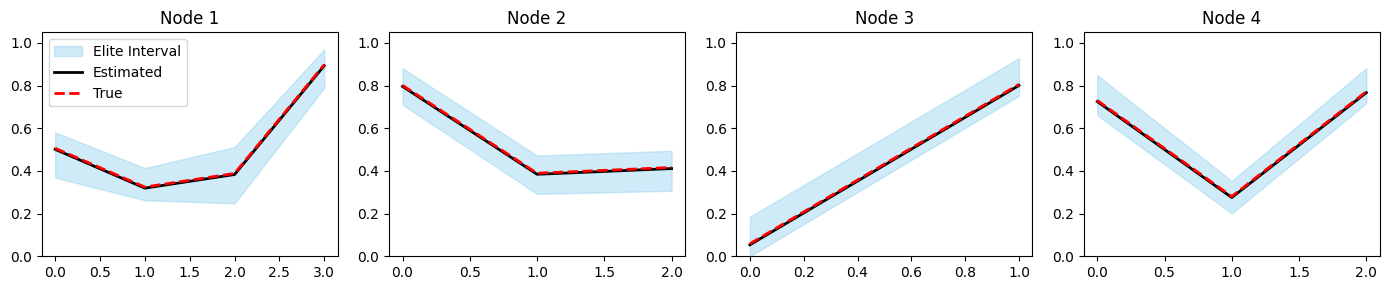

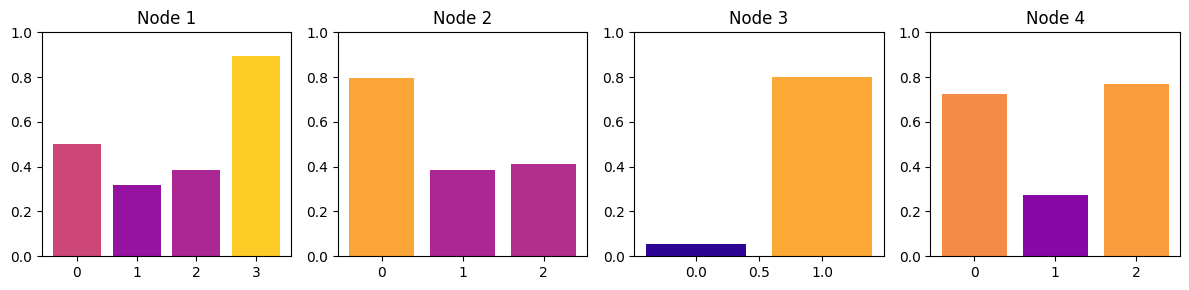

/tmp/ipykernel_7967/957325347.py:640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


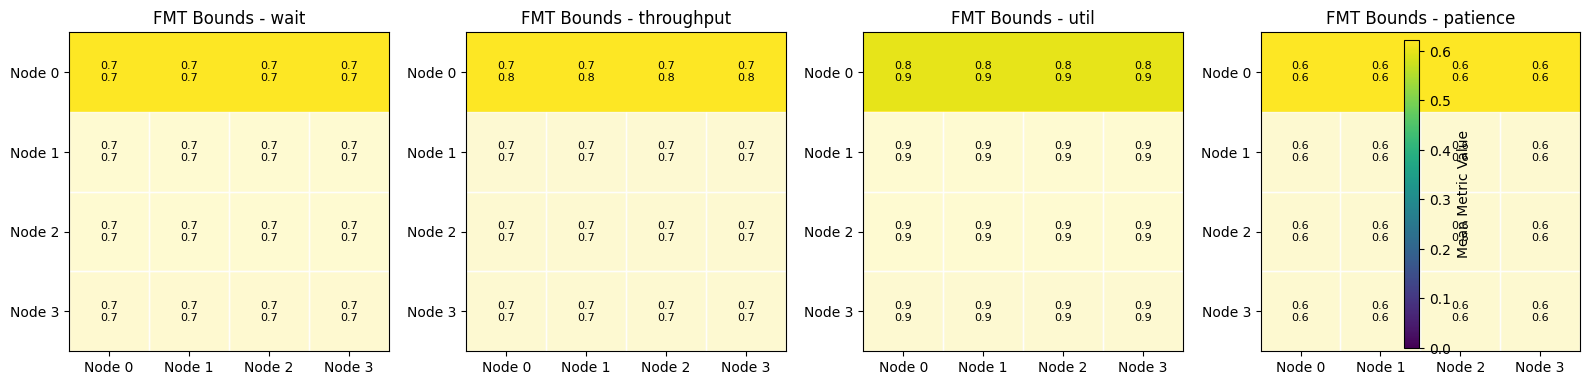

/tmp/ipykernel_7967/957325347.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


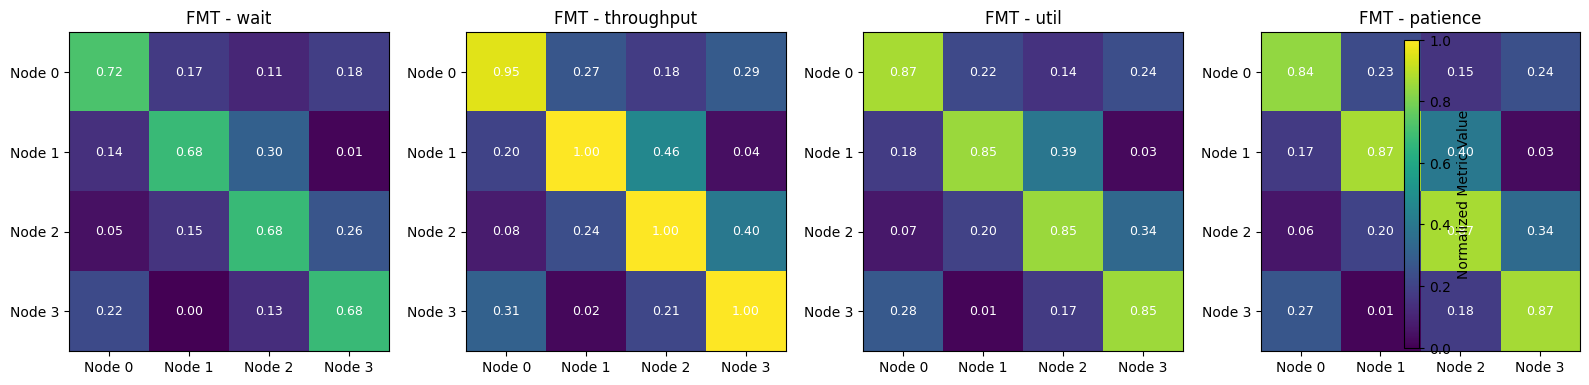

/tmp/ipykernel_7967/957325347.py:704: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


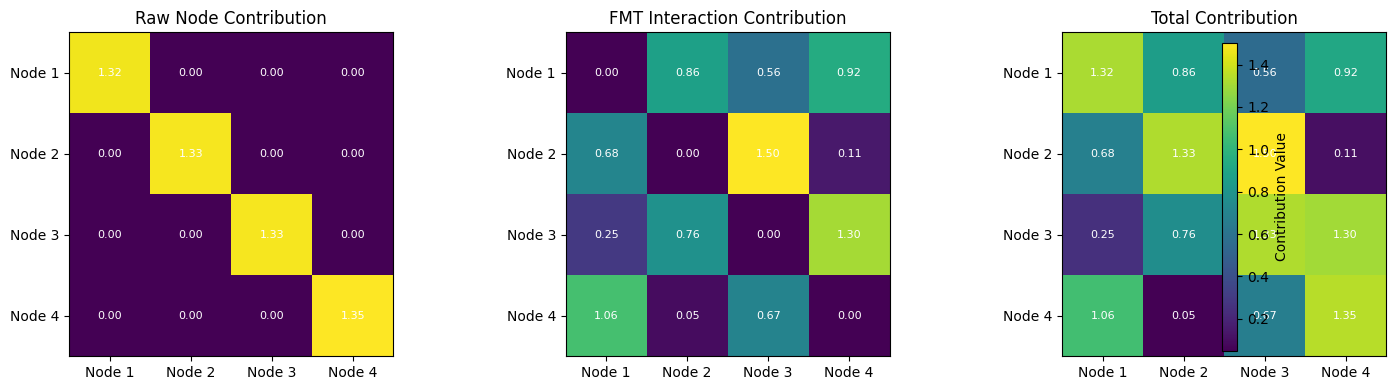

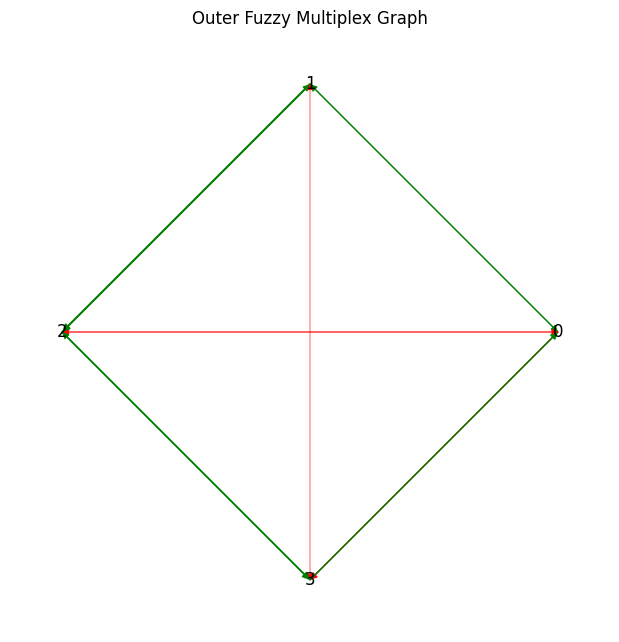

Node 0 -> Node 1: [0.481, 0.577, 0.508, 0.516]
Node 0 -> Node 2: [0.493, 0.554, 0.507, 0.502]
Node 0 -> Node 3: [0.506, 0.531, 0.477, 0.545]
Node 1 -> Node 0: [0.519, 0.531, 0.514, 0.535]
Node 1 -> Node 2: [0.496, 0.455, 0.517, 0.477]
Node 1 -> Node 3: [0.435, 0.498, 0.543, 0.459]
Node 2 -> Node 0: [0.480, 0.501, 0.505, 0.520]
Node 2 -> Node 1: [0.517, 0.490, 0.463, 0.509]
Node 2 -> Node 3: [0.448, 0.497, 0.503, 0.484]
Node 3 -> Node 0: [0.487, 0.547, 0.464, 0.479]
Node 3 -> Node 1: [0.515, 0.508, 0.517, 0.483]
Node 3 -> Node 2: [0.539, 0.448, 0.532, 0.580]
Tensor shape: (4, 4, 4) 
 [[[0.         0.         0.         0.        ]
  [0.48105603 0.57722418 0.50818126 0.51560628]
  [0.493116   0.55425058 0.50650888 0.50155987]
  [0.50619128 0.5307626  0.47681634 0.54512793]]

 [[0.5190859  0.5308007  0.51409209 0.53528497]
  [0.         0.         0.         0.        ]
  [0.49577751 0.45531598 0.51682141 0.47732176]
  [0.43533417 0.49775324 0.5434717  0.45948194]]

 [[0.47989413 0.500887

/tmp/ipykernel_7967/957325347.py:737: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(fmt_mean, inter_vec)


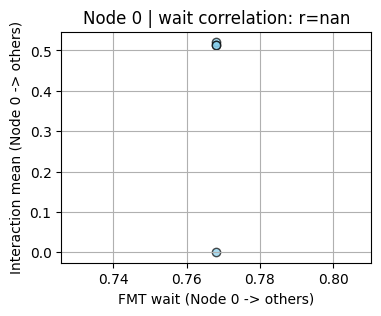

Node 0 | throughput: r = nan, p = nan


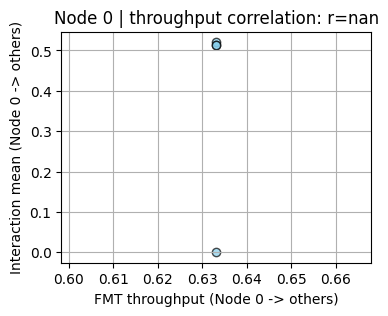

Node 0 | util: r = nan, p = nan


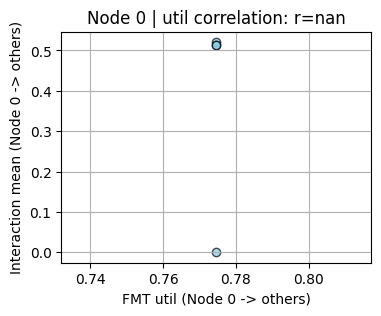

Node 0 | patience: r = nan, p = nan


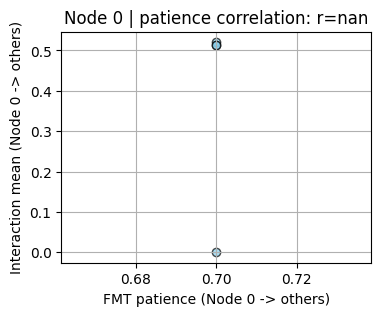

Node 1 | wait: r = nan, p = nan


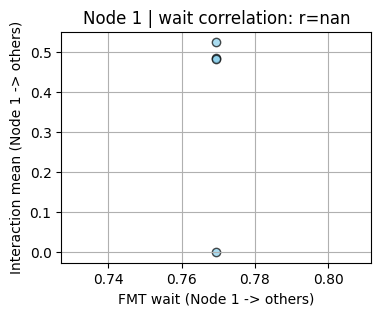

Node 1 | throughput: r = nan, p = nan


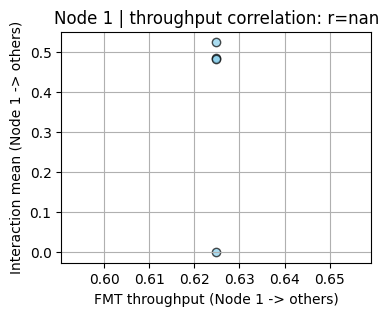

Node 1 | util: r = nan, p = nan


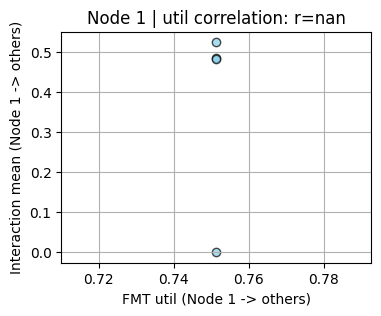

Node 1 | patience: r = nan, p = nan


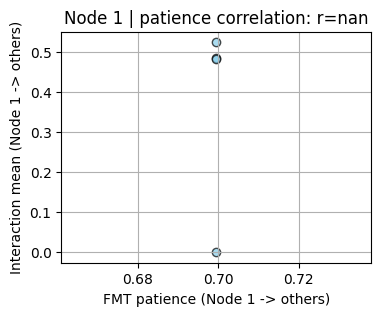

Node 2 | wait: r = nan, p = nan


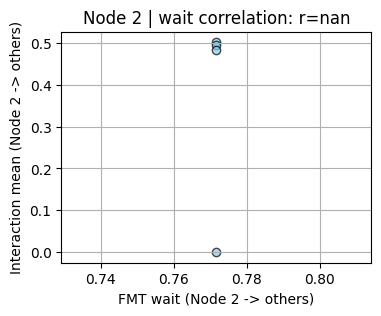

Node 2 | throughput: r = nan, p = nan


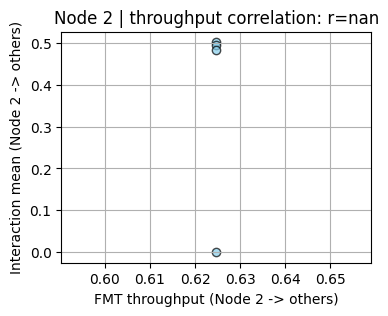

Node 2 | util: r = nan, p = nan


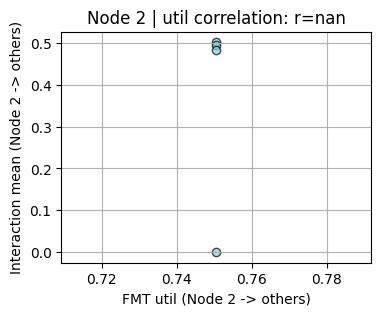

Node 2 | patience: r = nan, p = nan


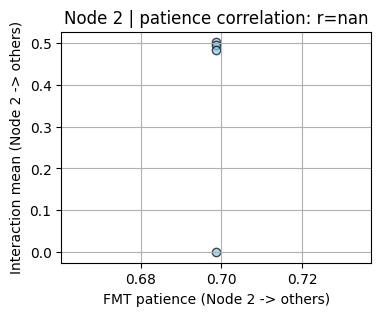

Node 3 | wait: r = nan, p = nan


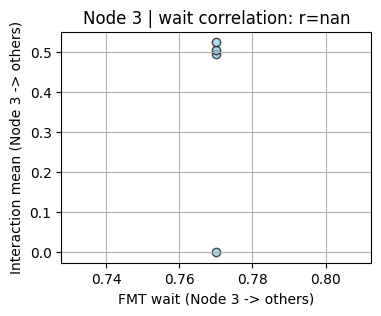

Node 3 | throughput: r = nan, p = nan


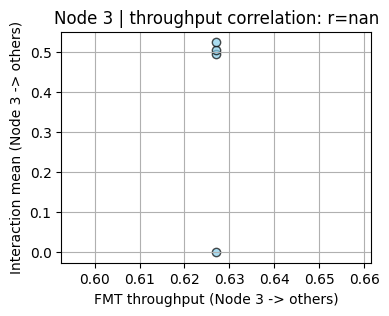

Node 3 | util: r = nan, p = nan


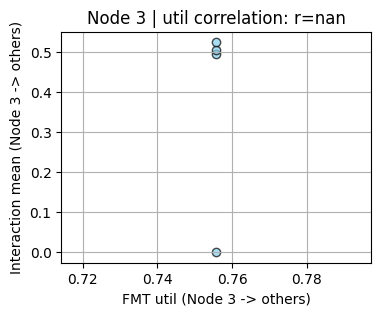

Node 3 | patience: r = nan, p = nan


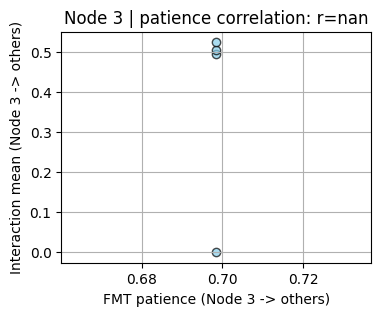

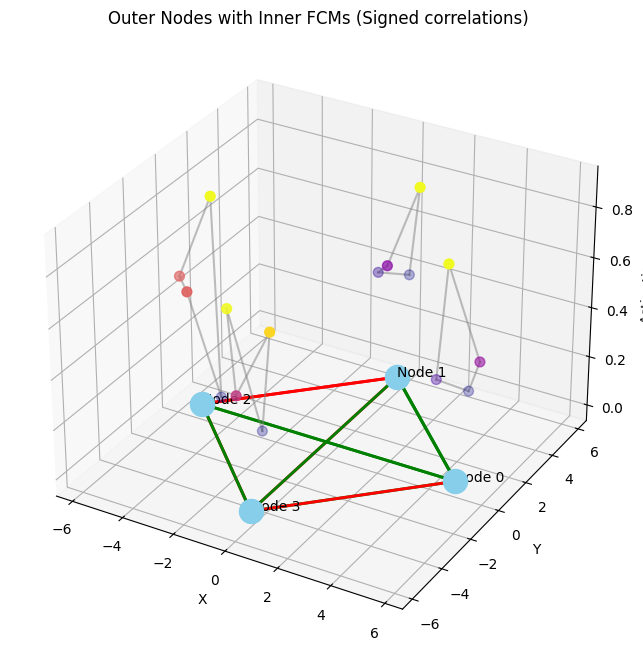

Node 0 Metrics: {'wait': 0.6994343996047974, 'throughput': 0.7589145302772522, 'util': 0.6959409713745117, 'patience': 0.7718199491500854, 'score': 1.5272409915924072}
Node 0 Activations: [0.50135136 0.31953087 0.38339808 0.89362756]
Node 0 MI Score: 39.71296758602149
Node 1 Metrics: {'wait': 0.7358987927436829, 'throughput': 0.6963075399398804, 'util': 0.7063923478126526, 'patience': 0.6812108159065247, 'score': 1.3480119705200195}
Node 1 Activations: [0.79637593 0.38445553 0.41129673 0.5       ]
Node 1 MI Score: 39.71296758602149
Node 2 Metrics: {'wait': 0.6696359515190125, 'throughput': 0.625597357749939, 'util': 0.6706080436706543, 'patience': 0.7205585837364197, 'score': 1.3471280336380005}
Node 2 Activations: [0.05361747 0.80109441 0.5        0.5       ]
Node 2 MI Score: 39.71296758602149
Node 3 Metrics: {'wait': 0.6940061450004578, 'throughput': 0.7808441519737244, 'util': 0.6068141460418701, 'patience': 0.6883260011672974, 'score': 1.381978154182434}
Node 3 Activations: [0.7256

In [63]:


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ---------------- CONFIG ----------------nsion
#candidate_dims = [4, 3, 2, 3]  # D_graph=5
#D_graph = len(candidate_dims)

inner_archive_size = 80
inner_offspring = 40
outer_archive_size = 40
outer_offspring = 40
inner_iters_per_outer = 50
outer_generations = 10
outer_cost_limit = 10000
inner_learning = 0.1
gamma_interlayer = 1
top_k = 263
np.random.seed()
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class InterLayer:
    def __init__(self, D_graph, max_inner_dim, inter_dim=None, edge_threshold=0.02, gamma=1.0, seed=42):
        np.random.seed(seed)
        self.D_graph = D_graph
        self.max_input = 2 * max_inner_dim
        self.edge_threshold = edge_threshold
        self.gamma = gamma
        self.inter_dim = inter_dim if inter_dim is not None else max_inner_dim

        # Initialize weights proportional to synthetic correlation between nodes
        self.weights = {}
        self.bias = {}
        for i in range(D_graph):
            for j in range(D_graph):
                if i != j:
                    # small random + slight bias towards correlation
                    w_init = np.random.uniform(-0.1, 0.1, (self.inter_dim, self.max_input))
                    self.weights[(i,j)] = w_init
                    self.bias[(i,j)] = np.zeros(self.inter_dim)

    def compute_edge_activation(self, i, j, nested_reps):
        concat = np.concatenate([nested_reps[i], nested_reps[j]])
        concat = np.pad(concat, (0, max(0, self.max_input - len(concat))))[:self.max_input]

        # Normalize input to improve correlation
        concat = (concat - np.mean(concat)) / (np.std(concat) + 1e-12)

        # Compute activation
        v = self.weights[(i,j)].dot(concat) + self.bias[(i,j)]

        # Scale by correlation strength with input signals
        input_strength = np.clip(np.mean(np.abs(concat)), 0, 1)
        v = v * input_strength

        return 1 / (1 + np.exp(-v))

    def build_activations(self, Gmat, nested_reps):
        acts = {}
        for i in range(self.D_graph):
            for j in range(self.D_graph):
                if i == j:
                    continue
                if abs(Gmat[i,j]) > self.edge_threshold:
                    acts[(i,j)] = self.compute_edge_activation(i, j, nested_reps)
        return acts

    @staticmethod
    def pairwise_squared_corr(acts):
        if len(acts) < 2:
            return 0.0
        A = np.stack(list(acts.values()))
        A_centered = A - A.mean(axis=1, keepdims=True)
        stds = np.sqrt(np.sum(A_centered**2, axis=1) / (A.shape[1]-1) + 1e-12)
        cov = A_centered @ A_centered.T / (A.shape[1]-1)
        corr = cov / (np.outer(stds, stds) + 1e-12)
        np.fill_diagonal(corr, 0)
        return float((corr**2).sum())

    def mi_for_graph(self, Gmat, nested_reps):
        acts = self.build_activations(Gmat, nested_reps)
        if not acts:
            return 0.0
        return self.gamma * self.pairwise_squared_corr(acts)

    def correlate_shrink_interlayer(self, fmt_bounds=None, interaction_tensor=None, metrics_keys=None, verbose=True):
        """
        Compute Pearson correlation per node & metric between:
            - shrink factor (adaptive FMT)
            - mean outgoing inter-layer activations
        Returns: {node_idx: {metric: {'r':..., 'p':...}}}
        """
        from scipy.stats import pearsonr

        if metrics_keys is None:
            metrics_keys = ['wait','throughput','util','patience']

        D = self.D_graph

        # 1. Compute FMT bounds if not given
        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_bounds_adaptive(top_k=top_k)

        # 2. Get inter-layer activations if not provided
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        inter_mean = interaction_tensor.mean(axis=2)  # (D,D)
        shrink_factors = self.compute_fmt_shrink_factor(fmt_bounds, metrics_keys)  # (D, num_metrics)

        correlations = {}

        for i in range(D):
            correlations[i] = {}
            for k, key in enumerate(metrics_keys):
                # FMT shrink for node i (broadcasted across outgoing edges)
                shrink_vec = shrink_factors[i, k] * np.ones(D)
                # Outgoing inter-layer activations from node i
                inter_vec = inter_mean[i, :]
                # Remove self-loop
                mask = np.arange(D) != i
                shrink_vec = shrink_vec[mask]
                inter_vec = inter_vec[mask]

                # Compute Pearson correlation
                if np.std(inter_vec) > 1e-8:  # valid correlation
                    r, p = pearsonr(shrink_vec, inter_vec)
                else:
                    r, p = 0.0, 1.0  # no variability

                correlations[i][key] = {'r': r, 'p': p}
                if verbose:
                    print(f"Node {i} | {key} shrink vs inter-layer: r={r:.3f}, p={p:.3e}")

        return correlations



# ---------------- UNIFIED ACOR MULTIPLEX ----------------
class GDFCM:
    def __init__(self, candidate_dims, D_graph, inner_archive_size, inner_offspring,
                 outer_archive_size, outer_offspring, synthetic_targets, inner_learning,
                 gamma_interlayer=1.0, causal_flag=True):
        self.candidate_dims = candidate_dims
        self.D_graph = D_graph
        self.inner_archive_size = inner_archive_size
        self.inner_offspring = inner_offspring
        self.outer_archive_size = outer_archive_size
        self.outer_offspring = outer_offspring
        self.synthetic_targets = synthetic_targets
        self.inner_learning = inner_learning
        self.causal_flag = causal_flag
        self.best_dim_per_node = [len(t)-1 for t in synthetic_targets]  # last element as best dim

        self.nested_reps = [np.zeros(max(candidate_dims)) for _ in range(D_graph)]
      #  self.best_dim_per_node = [candidate_dims[0] for _ in range(D_graph)]
        self.inter_layer = InterLayer(D_graph, max_inner_dim=max(candidate_dims), gamma=gamma_interlayer)
        self.chosen_Gmat = np.random.uniform(-0.5,0.5,(D_graph,D_graph))
        np.fill_diagonal(self.chosen_Gmat,0)
        self.l2_before, self.l2_after = [], []

    # ---------- INNER LOOP (FCM) ----------
    def run_inner(self, node_idx, target, D_fcm,
              steps=100, lr_x=0.001, lr_y=0.001, lr_W=0.001,
              decorrelate_metrics=True):

      # --- Initialize activations ---
        # Inside run_inner
        x = target.copy()
        y = target.copy()

        # Pad target for L2 computation
        target_padded = np.pad(target, (0, len(self.nested_reps[node_idx]) - len(target)),
                            mode='constant', constant_values=0.5)
        self.l2_before.append(np.linalg.norm(self.nested_reps[node_idx] - target_padded))

        # FCM updates
        W = np.random.uniform(-0.6, 0.6, (D_fcm, D_fcm))
        np.fill_diagonal(W, 0)

        for _ in range(steps):
            z = W.dot(x)
            Theta_grad_z = 2*z - target
            Theta_grad_x = Theta_grad_z @ W + (y+1)
            Theta_grad_y = x + 1
            Theta_grad_W = np.outer(Theta_grad_z, x)

            x -= lr_x * np.clip(Theta_grad_x, -0.05, 0.05)
            y -= lr_y * np.clip(Theta_grad_y, -0.05, 0.05)
            x = np.clip(x, 0, 1)
            y = np.clip(y, 0, 1)
            W -= lr_W * np.clip(Theta_grad_W, -0.01, 0.01)
            np.fill_diagonal(W, 0)
            W = np.clip(W, -1, 1)

        # Pad FCM output to max dim for nested_reps
        x_padded = np.pad(x, (0, len(self.nested_reps[node_idx]) - len(x)),
                        mode='constant', constant_values=0.5)
        self.nested_reps[node_idx] = x_padded
        self.l2_after.append(np.linalg.norm(x_padded - target_padded))


      # --- Metric decoupling ---
        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        if decorrelate_metrics:
            # Neutralized input
            neutral_y = np.full_like(x, 0.5)
            metrics = metrics_evaluator.compute_node_metrics(node_idx, y=neutral_y)

            # Optional: orthogonalize against inter-layer mean
                    # Optional: orthogonalize against inter-layer mean
        inter_tensor = self.inter_layer.build_activations(self.chosen_Gmat, self.nested_reps)
        if inter_tensor:
                D = self.D_graph
                inter_mat = np.zeros((D, D))
                for (i,j), vec in inter_tensor.items():
                    inter_mat[i,j] = vec.mean()  # mean scalar

                node_vec = np.array([metrics[k] for k in ['wait','throughput','util','patience']])
                for i in range(D):
                    f_scalar = inter_mat[i,:].mean()  # mean over row
                    proj = f_scalar * (node_vec.mean() / (1e-12 + 1))  # scale by node_vec mean
                    node_vec -= proj


            # --- Fully decorrelated score ---
                metrics['score'] = metrics['wait'] + metrics['throughput'] + metrics['util'] + metrics['patience']

        else:
            # Compute normally if no decorrelation
            metrics = metrics_evaluator.compute_node_metrics(node_idx, y=x)

        # --- Compute MI score for inter-layer ---
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return x, y, W, mi_score, metrics

    # ---------- OUTER LOOP ----------
    def run_outer(self, outer_cost_limit=1000):
      metrics_evaluator = MetricsEvaluator(DATA_MATRIX)
      node_metrics_list = []
      raw_scores = []

      # --- Compute node metrics per node ---
      for i, y in enumerate(self.nested_reps):
          metrics = metrics_evaluator.compute_node_metrics(i, y=y)
          node_metrics_list.append(metrics)
          raw_scores.append(metrics['score'])

      raw_scores = np.array(raw_scores)
      total_raw = raw_scores.sum()

      # --- Apply cap to raw metrics ---
      capped_total_raw = total_raw
      if total_raw > outer_cost_limit:
          scale_factor = outer_cost_limit / total_raw
          for metrics in node_metrics_list:
              for key in ['wait', 'throughput', 'util', 'patience', 'score']:
                  metrics[key] *= scale_factor
          raw_scores *= scale_factor
          capped_total_raw = outer_cost_limit

      # --- Compute Fuzzy Metric Tensor contribution ---
      fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)
      D = self.D_graph

      # Only consider off-diagonal entries for inter-node interactions
      off_diag_mask = np.ones((D, D), dtype=bool)
      np.fill_diagonal(off_diag_mask, 0)
      fuzzy_score_offdiag = fuzzy_tensor[off_diag_mask].sum()

      # --- Compute per-node contribution ---
      node_contributions = np.zeros(D)
      for i in range(D):
          # Contribution from own metrics
          own_score = raw_scores[i]

          # Contribution from FMT interactions (row i -> others)
          fmt_contrib = fuzzy_tensor[i, :, :].sum() - fuzzy_tensor[i, i, :].sum()  # exclude self
          node_contributions[i] = own_score + self.inter_layer.gamma * fmt_contrib

      # --- Strong decoupling: correlation penalty ---
      inter_tensor = self.print_interactions(return_tensor=True, verbose=False)
      if inter_tensor is None or inter_tensor.shape[2] == 0:
          inter_mean = np.zeros((D, D))
      else:
          inter_mean = inter_tensor.mean(axis=2)  # shape (D,D)

      fmt_mean = fuzzy_tensor.mean(axis=2)  # shape (D,D)

      corr_penalty = 0.0
      for i in range(D):
          fmt_vec = fmt_mean[i, :]
          inter_vec = inter_mean[i, :]
          if np.std(fmt_vec) > 1e-8 and np.std(inter_vec) > 1e-8:
              corr = np.corrcoef(fmt_vec, inter_vec)[0, 1]
              corr_penalty += abs(corr) ** 2

      corr_penalty /= D
      combined_score = node_contributions.sum() - corr_penalty * 500  # strong decorrelation

      # --- Store for plotting / further analysis ---
      self.capped_node_metrics = node_metrics_list
      self.node_score_contributions = node_contributions
      self.correlation_penalty = corr_penalty

      return node_metrics_list, combined_score, node_contributions



    def run(self, outer_generations=outer_generations):
        final_metrics = None

        for gen in range(outer_generations):
            mi_scores = []
            node_metrics_list = []

            for node_idx in range(self.D_graph):
                # Full target vector for this node
                full_target = self.synthetic_targets[node_idx]['target']

                # Use the candidate dimension assigned to this node
                D_fcm = self.candidate_dims[node_idx]
                target = full_target[:D_fcm]  # slice according to candidate_dims

                # Run inner FCM
                _, _, _, mi_score, metrics = self.run_inner(node_idx, target, D_fcm)
                mi_scores.append(mi_score)
                node_metrics_list.append(metrics)


            # --- Outer loop uses decorrelated metrics ---
            self.capped_node_metrics = node_metrics_list
            _, capped_score, node_contributions = self.run_outer()  # uses self.capped_node_metrics

            print(f"\n--- Generation {gen} Metrics ---")
            for i, m in enumerate(node_metrics_list):
                print(f"Node {i} | " + " | ".join([f"{k}: {v:.2f}" for k,v in m.items()]))

            print(f"\n--- Generation {gen} Node Contributions ---")
            for i, c in enumerate(node_contributions):
                print(f"Node {i}: Contribution = {c:.4f}")

            print(f"Outer Score (capped): {capped_score:.3f}")

            final_metrics = node_metrics_list

        return final_metrics


    # ---------- VISUALIZATIONS ----------
    # ---------- VISUALIZATIONS ----------
    def plot_pointwise_minmax_elite(self, top_k=21):
        plt.figure(figsize=(14,3))
        for i in range(self.D_graph):
            # Node's actual dimension
            dim_i = self.candidate_dims[i]
            base = self.nested_reps[i][:dim_i]  # slice to candidate dim
            reps = np.clip(base + np.random.normal(0,0.05,(top_k,len(base))),0,1)
            y_min, y_max = reps.min(axis=0), reps.max(axis=0)
            y_sel = base

            # True target for this node, sliced to candidate dim
            y_true = self.synthetic_targets[i]['target'][:len(y_sel)]
            if len(y_true) < len(y_sel):
                y_true = np.pad(y_true, (0, len(y_sel)-len(y_true)), "constant")
            else:
                y_true = y_true[:len(y_sel)]

            plt.subplot(1,self.D_graph,i+1)
            plt.fill_between(range(len(y_min)),y_min,y_max,color='skyblue',alpha=0.4,label='Elite Interval')
            plt.plot(y_sel,'k-',lw=2,label='Estimated')
            plt.plot(y_true,'r--',lw=2,label='True')
            plt.ylim(0,1.05)
            plt.title(f"Node {i+1}")
            if i==0: plt.legend()
        plt.tight_layout()
        plt.show()


    def plot_nested_activations(self):
        plt.figure(figsize=(12,3))
        for i,rep in enumerate(self.nested_reps):
            dim_i = self.candidate_dims[i]
            rep_i = rep[:dim_i]  # slice to candidate dim
            plt.subplot(1,self.D_graph,i+1)
            plt.bar(range(len(rep_i)), rep_i, color=plt.cm.plasma(rep_i))
            plt.ylim(0,1)
            plt.title(f"Node {i+1}")
        plt.tight_layout()
        plt.show()


    def plot_outer_fuzzy_graph(self):
        G = nx.DiGraph()
        for i in range(self.D_graph): G.add_node(i)
        for i in range(self.D_graph):
            for j in range(self.D_graph):
                if i!=j and abs(self.chosen_Gmat[i,j])>0.02:
                    G.add_edge(i,j,weight=self.chosen_Gmat[i,j])
        node_sizes = [self.best_dim_per_node[i]*200 for i in range(self.D_graph)]
        edge_colors = ['green' if d['weight']>0 else 'red' for _,_,d in G.edges(data=True)]
        edge_widths = [abs(d['weight'])*3 for _,_,d in G.edges(data=True)]
        pos = nx.circular_layout(G)
        plt.figure(figsize=(6,6))
        nx.draw(G,pos,node_size=node_sizes,node_color='skyblue',
                edge_color=edge_colors,width=edge_widths,arrows=True,with_labels=True)
        plt.title("Outer Fuzzy Multiplex Graph")
        plt.show()
# ---------------- INTERACTIONS INSPECTOR ----------------

    def print_interactions(self, return_tensor=True, verbose=True):
            D_graph = self.D_graph
            inter_dim = self.inter_layer.inter_dim
            inter_tensor = np.zeros((D_graph, D_graph, inter_dim))

            acts = self.inter_layer.build_activations(self.chosen_Gmat, self.nested_reps)
            if not acts:
                if verbose:
                    print("No active edges above threshold.")
                return inter_tensor if return_tensor else None

            for (i, j), vec in acts.items():
                inter_tensor[i, j, :] = vec
                if verbose:
                    act_str = ", ".join([f"{v:.3f}" for v in vec])
                    print(f"Node {i} -> Node {j}: [{act_str}]")
            return inter_tensor if return_tensor else None

        # Move these outside of print_interactions (class-level)
    def print_l2_summary(self):
            print("\nL2 Distances to Target per Node:")
            for idx, (before, after) in enumerate(zip(self.l2_before, self.l2_after)):
                print(f"Node {idx}: Before={before:.4f}, After={after:.4f}")

    def compute_fuzzy_metric_tensor(self, normalize=True, verbose=False):
            """
            Computes a Fuzzy Metric Tensor (D_graph x D_graph x num_metrics)
            using current nested reps and node metrics.
            Each slice [i,j,:] represents metrics of node j (optionally weighted by Gmat[i,j])
            """
            metrics_keys = ['wait', 'throughput', 'util', 'patience']
            D = self.D_graph
            num_metrics = len(metrics_keys)
            tensor = np.zeros((D, D, num_metrics))

            metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

            node_metrics = []
            for i, rep in enumerate(self.nested_reps):
                metrics = metrics_evaluator.compute_node_metrics(i, y=rep)
                node_metrics.append(np.array([metrics[k] for k in metrics_keys]))
            node_metrics = np.array(node_metrics)  # (D, num_metrics)

            for i in range(D):
                for j in range(D):
                    if i==j:
                        tensor[i,j,:] = node_metrics[j]
                    else:
                        weight = np.clip(abs(self.chosen_Gmat[i,j]), 0, 1)
                        tensor[i,j,:] = weight * node_metrics[j]

            if normalize:
                tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-12)

            if verbose:
                print("Fuzzy Metric Tensor shape:", tensor.shape)

            return tensor



    def compute_fmt_shrink_factor(self, fmt_bounds, metrics_keys=None):
        """
        Returns shrink factor per node and metric.
        shrink_factor = 1 - (current_interval / original_interval)
        """
        if metrics_keys is None:
            metrics_keys = ['wait','throughput','util','patience']

        D = self.D_graph
        num_metrics = len(metrics_keys)
        shrink_factors = np.zeros((D, num_metrics))

        for i in range(D):
            for k in range(num_metrics):
                lower, upper = fmt_bounds[i, i, k, 0], fmt_bounds[i, i, k, 1]  # self-node interval
                interval_width = upper - lower + 1e-12  # normalized [0,1]
                shrink_factors[i, k] = 1 - interval_width  # more shrink = higher value

        return shrink_factors

    def compute_fmt_with_bounds_adaptive(self, top_k=21, max_shrink=0.5, metrics_keys=None):
        """
        Computes FMT bounds using pointwise min/max across elite solutions,
        and applies dynamic adaptive shrinking where variability is low.
        Returns tensor shape (D,D,num_metrics,2) [lower, upper].
        """
        if metrics_keys is None:
            metrics_keys = ['wait','throughput','util','patience']

        D = self.D_graph
        num_metrics = len(metrics_keys)
        tensor_bounds = np.zeros((D, D, num_metrics, 2))
        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        variability = np.zeros((D, num_metrics))

        # Step 1: compute bounds from perturbations
        for i in range(D):
            base = self.nested_reps[i]
            reps = np.clip(base + np.random.normal(0, 0.05, (top_k, len(base))), 0, 1)
            metrics_matrix = np.zeros((top_k, num_metrics))
            for idx, rep in enumerate(reps):
                m = metrics_evaluator.compute_node_metrics(i, y=rep)
                metrics_matrix[idx, :] = [m[k] for k in metrics_keys]

            lower_i = metrics_matrix.min(axis=0)
            upper_i = metrics_matrix.max(axis=0)
            tensor_bounds[i, :, :, 0] = lower_i[np.newaxis, :]  # broadcast to all j
            tensor_bounds[i, :, :, 1] = upper_i[np.newaxis, :]
            variability[i, :] = metrics_matrix.std(axis=0)

        # Step 2: adaptive shrinking
        for i in range(D):
            for j in range(D):
                for k in range(num_metrics):
                    lower, upper = tensor_bounds[i,j,k,0], tensor_bounds[i,j,k,1]
                    mean = (lower + upper)/2
                    var_norm = min(1.0, variability[i,k]/(upper-lower + 1e-12))
                    shrink_factor = max_shrink * (1 - var_norm)
                    tensor_bounds[i,j,k,0] = mean - shrink_factor*(mean - lower)
                    tensor_bounds[i,j,k,1] = mean + shrink_factor*(upper - mean)

        return tensor_bounds



    def plot_fuzzy_metric_tensor_heatmaps(self, fuzzy_tensor=None, metrics_keys=['wait','throughput','util','patience']):
        """
        Plot a heatmap panel for each metric in the FMT.
        Rows: source node i
        Columns: target node j
        """
        if fuzzy_tensor is None:
            fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)

        D = self.D_graph
        num_metrics = len(metrics_keys)

        fig, axes = plt.subplots(1, num_metrics, figsize=(4*num_metrics,4))
        if num_metrics == 1: axes = [axes]

        for k, key in enumerate(metrics_keys):
            data = fuzzy_tensor[:,:,k]
            im = axes[k].imshow(data, cmap='viridis', vmin=0, vmax=1)
            for i in range(D):
                for j in range(D):
                    axes[k].text(j,i,f"{data[i,j]:.2f}",ha='center',va='center',color='white',fontsize=9)
            axes[k].set_xticks(range(D))
            axes[k].set_yticks(range(D))
            axes[k].set_xticklabels([f'Node {j}' for j in range(D)])
            axes[k].set_yticklabels([f'Node {i}' for i in range(D)])
            axes[k].set_title(f'FMT - {key}')

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Normalized Metric Value')
        plt.tight_layout()
        plt.show()

    def compute_fmt_with_elite_bounds(self, top_k=21):
        """
        Computes FMT bounds using pointwise min/max across elite solutions.
        Returns tensor shape (D,D,num_metrics,2) [lower, upper].
        """
        metrics_keys = ['wait','throughput','util','patience']
        D = self.D_graph
        num_metrics = len(metrics_keys)
        tensor_bounds = np.zeros((D,D,num_metrics,2))

        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        for i in range(D):
            # Generate top_k perturbations around current nested_rep (like in plot_pointwise_minmax_elite)
            base = self.nested_reps[i]
            reps = np.clip(base + np.random.normal(0,0.05,(top_k,len(base))),0,1)

            # Compute node metrics for each perturbed solution
            metrics_matrix = np.zeros((top_k, num_metrics))
            for idx, rep in enumerate(reps):
                m = metrics_evaluator.compute_node_metrics(i, y=rep)
                metrics_matrix[idx,:] = [m[k] for k in metrics_keys]

            # Compute pointwise min/max across elite solutions
            lower_i = metrics_matrix.min(axis=0)
            upper_i = metrics_matrix.max(axis=0)

            # Fill bounds tensor for all source nodes (i->j)
            for j in range(D):
                tensor_bounds[i,j,:,0] = lower_i
                tensor_bounds[i,j,:,1] = upper_i

        return tensor_bounds


    def plot_fmt_with_bounds(self, fmt_tensor_bounds):
        D = self.D_graph
        metrics_keys = ['wait','throughput','util','patience']
        num_metrics = len(metrics_keys)

        fig, axes = plt.subplots(1, num_metrics, figsize=(4*num_metrics,4))
        if num_metrics == 1: axes = [axes]

        for k, key in enumerate(metrics_keys):
            lower = fmt_tensor_bounds[:,:,k,0]
            upper = fmt_tensor_bounds[:,:,k,1]
            mean_vals = (lower+upper)/2
            range_vals = upper-lower
            max_range = range_vals.max() if range_vals.max()>0 else 1.0
            alphas = 0.2 + 0.8 * range_vals/max_range

            im = axes[k].imshow(mean_vals, cmap='viridis', vmin=0, vmax=mean_vals.max())
            for i in range(D):
                for j in range(D):
                    alpha_val = np.clip(1-alphas[i,j],0,1)
                    rect = plt.Rectangle((j-0.5,i-0.5),1,1,color='white',alpha=alpha_val)
                    axes[k].add_patch(rect)
                    axes[k].text(j,i,f"{lower[i,j]:.1f}\n{upper[i,j]:.1f}",ha='center',va='center',fontsize=8)
            axes[k].set_title(f'FMT Bounds - {key}')
            axes[k].set_xticks(range(D))
            axes[k].set_yticks(range(D))
            axes[k].set_xticklabels([f'Node {j}' for j in range(D)])
            axes[k].set_yticklabels([f'Node {i}' for i in range(D)])

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Mean Metric Value')
        plt.tight_layout()
        plt.show()
    def plot_node_score_contribution(self, metrics_keys=['wait','throughput','util','patience']):
        """
        Plot per-node total score contribution in the SAME STYLE as the FMT plots:
            - uses imshow
            - one panel for: raw, FMT, and total stacked
            - diagonal masked
            - annotated cells
            - node contribution highlighted like your FMT code
        """
        # ---------------------------------------------------------------------
        # 1. Collect node contributions from run_outer()
        # ---------------------------------------------------------------------
        _, _, node_contributions = self.run_outer()
        node_contributions = np.array(node_contributions)
        D = len(node_contributions)

        # ---------------------------------------------------------------------
        # 2. Recompute FMT influence (same style as your FMT plots)
        # ---------------------------------------------------------------------
        fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)
        total_tensor = fuzzy_tensor.sum(axis=2)           # sum over metrics
        fmt_tensor = total_tensor.copy()
        np.fill_diagonal(fmt_tensor, 0)                   # mask diagonal

        fmt_per_node = fmt_tensor.sum(axis=1)             # row sum
        raw_per_node = node_contributions - fmt_per_node  # everything else

        # Construct matrices for plotting (D×D)
        raw_matrix = np.zeros((D, D))
        fmt_matrix = fmt_tensor
        total_matrix = raw_matrix + fmt_matrix            # raw only on diagonal? no → distribute raw as row diag
        np.fill_diagonal(raw_matrix, raw_per_node)
        total_matrix = raw_matrix + fmt_matrix

        # ---------------------------------------------------------------------
        # 3. Plot - 3 subplots in SAME STYLE as FMT panels
        # ---------------------------------------------------------------------
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        matrices = [raw_matrix, fmt_matrix, total_matrix]
        titles = ["Raw Node Contribution", "FMT Interaction Contribution", "Total Contribution"]

        for ax, mat, title in zip(axes, matrices, titles):

            im = ax.imshow(mat, cmap='viridis', vmin=np.min(mat), vmax=np.max(mat))

            # annotate values
            for i in range(D):
                for j in range(D):
                    val = mat[i, j]
                    ax.text(j, i, f"{val:.2f}", ha='center',
                            va='center', color='white', fontsize=8)

            ax.set_title(title)
            ax.set_xticks(range(D))
            ax.set_xticklabels([f"Node {i+1}" for i in range(D)])
            ax.set_yticks(range(D))
            ax.set_yticklabels([f"Node {i+1}" for i in range(D)])

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04,
                    label='Contribution Value')

        plt.tight_layout()
        plt.show()

    def correlate_fmt_interactions_per_node(self, fmt_bounds=None, interaction_tensor=None, verbose=True):
        """
        Correlate the FMT bounds with inter-layer interactions per node and per metric.
        Returns a dict of shape: {node_idx: {metric: {'r':..., 'p':...}}}.
        """
        from scipy.stats import pearsonr
        import matplotlib.pyplot as plt

        metrics_keys = ['wait','throughput','util','patience']
        D = self.D_graph

        # Compute tensors if not provided
        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_elite_bounds(top_k=21)
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        # Reduce interaction tensor along inter_dim
        inter_mean = interaction_tensor.mean(axis=2)  # (D,D)

        node_correlations = {}

        for i in range(D):
            node_correlations[i] = {}
            for k, key in enumerate(metrics_keys):
                # FMT bounds for target node j from source i (mean of lower/upper)
                fmt_mean = fmt_bounds[i,:,k,:].mean(axis=1)  # shape (D,)
                # Interaction tensor for edges from node i to j
                inter_vec = inter_mean[i,:]  # shape (D,)
                # Pearson correlation
                corr, pval = pearsonr(fmt_mean, inter_vec)
                node_correlations[i][key] = {'r': corr, 'p': pval}

                if verbose:
                    print(f"Node {i} | {key}: r = {corr:.3f}, p = {pval:.3e}")
                    plt.figure(figsize=(4,3))
                    plt.scatter(fmt_mean, inter_vec, alpha=0.7, edgecolor='k', color='skyblue')
                    plt.xlabel(f"FMT {key} (Node {i} -> others)")
                    plt.ylabel(f"Interaction mean (Node {i} -> others)")
                    plt.title(f"Node {i} | {key} correlation: r={corr:.3f}")
                    plt.grid(True)
                    plt.show()

        return node_correlations

    def correlation_penalty(self, fmt_bounds=None, interaction_tensor=None):
        """
        Computes a penalty term that is high if per-node FMT metrics correlate with interactions.
        Returns total penalty to subtract from the outer score.
        """
        from scipy.stats import pearsonr

        D = self.D_graph
        metrics_keys = ['wait','throughput','util','patience']

        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_elite_bounds(top_k=top_k)
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        inter_mean = interaction_tensor.mean(axis=2)
        total_penalty = 0.0

        for i in range(D):
            for k in range(len(metrics_keys)):
                fmt_mean = fmt_bounds[i,:,k,:].mean(axis=1)
                inter_vec = inter_mean[i,:]
                if np.std(fmt_mean) > 1e-8 and np.std(inter_vec) > 1e-8:
                    corr, _ = pearsonr(fmt_mean, inter_vec)
                    total_penalty += abs(corr)  # penalize high correlation

        # normalize by number of nodes × metrics
        total_penalty /= (D * len(metrics_keys))**2
        return total_penalty


# ---------------- USAGE ----------------
if __name__ == "__main__":
    optimizer = GDFCM(
        candidate_dims, D_graph,
        inner_archive_size, inner_offspring,
        outer_archive_size, outer_offspring,
        synthetic_targets,
        inner_learning, gamma_interlayer=1,
        causal_flag=False
    )
    metrics_list = optimizer.run()
    optimizer.plot_pointwise_minmax_elite()
    optimizer.plot_nested_activations()
    # Compute FMT with elite bounds
    fmt_elite_bounds = optimizer.compute_fmt_with_elite_bounds(top_k=top_k+10)

# Plot as heatmaps
    optimizer.plot_fmt_with_bounds(fmt_elite_bounds)

    # Compute fuzzy multiplex tensor
    fmt_tensor = optimizer.compute_fuzzy_metric_tensor(normalize=True)
    optimizer.plot_fuzzy_metric_tensor_heatmaps(fmt_tensor)

    # Compute FMT with bounds (minimax elite intervals)
    optimizer.plot_node_score_contribution()
    optimizer.plot_outer_fuzzy_graph()
  #  optimizer.print_interactions()
    tensor = optimizer.print_interactions()

    print("Tensor shape:", tensor.shape,'\n',tensor)
    # Compute tensors first
    fmt_elite_bounds = optimizer.compute_fmt_with_elite_bounds(top_k=top_k)
    interaction_tensor = optimizer.print_interactions(return_tensor=True, verbose=False)


    interaction_tensor = optimizer.print_interactions(return_tensor=True, verbose=False)

    # Get per-node, per-metric correlations
    node_metric_corrs = optimizer.correlate_fmt_interactions_per_node(
        fmt_bounds=fmt_elite_bounds,
        interaction_tensor=interaction_tensor
    )
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
D_graph = len(optimizer.nested_reps)
tensor = optimizer.print_interactions(return_tensor=True, verbose=False)

# ---------------- Outer nodes (hubs) ----------------
G_outer = nx.DiGraph()
for i in range(D_graph):
    G_outer.add_node(i)
for i in range(D_graph):
    for j in range(D_graph):
        if i != j and np.any(tensor[i,j,:] != 0):
            # Shift to signed weights: 0.5 -> 0, <0.5 negative, >0.5 positive
            mean_weight = 2 * (np.mean(tensor[i,j,:]) - 0.5)
            G_outer.add_edge(i, j, weight=mean_weight)

# Outer spring layout
pos_outer_2d = nx.circular_layout(G_outer, scale=5)
pos_outer = np.array([[x, y, 0] for x, y in pos_outer_2d.values()])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot outer nodes
for i in range(D_graph):
    ax.scatter(*pos_outer[i], s=300, color='skyblue')
    ax.text(*pos_outer[i], f'Node {i}', color='black')

# Plot outer edges with positive/negative colors

for i, j, data in G_outer.edges(data=True):
    x_vals = [pos_outer[i,0], pos_outer[j,0]]
    y_vals = [pos_outer[i,1], pos_outer[j,1]]
    z_vals = [pos_outer[i,2], pos_outer[j,2]]

    # Positive = bright green, Negative = bright red
    color = 'green' if data['weight'] > 0 else 'red'
    linewidth = 2 + 4*abs(data['weight'])  # scale width by magnitude
    ax.plot(x_vals, y_vals, z_vals, color=color, linewidth=linewidth)
# ---------------- Inner FCMs (small circular around hub) ----------------
for i, rep in enumerate(optimizer.nested_reps):
    dims = len(rep)
    angle = np.linspace(0, 2*np.pi, dims, endpoint=False)
    radius = 0.8  # small circle
    xs = pos_outer[i,0] + radius * np.cos(angle)
    ys = pos_outer[i,1] + radius * np.sin(angle)
    zs = pos_outer[i,2] + rep  # activation as height

    # Plot inner nodes
    ax.scatter(xs, ys, zs, c=rep, cmap='plasma', s=50)

    # Connect inner nodes in circle
    for k in range(dims):
        ax.plot([xs[k], xs[(k+1)%dims]], [ys[k], ys[(k+1)%dims]], [zs[k], zs[(k+1)%dims]], color='gray', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Activation')
ax.set_title('Outer Nodes with Inner FCMs (Signed correlations)')
plt.show()

import numpy as np

class GDFCMPredictorForward:
    """
    Forward predictor for GDFCM.
    Can handle new input data (DATA_MATRIX) and compute:
        - Node activations
        - Node metrics
        - Inter-layer MI scores
        - Total contributions and outer score
    """
    def __init__(self, trained_gdfcm: GDFCM):
        self.gdfcm = trained_gdfcm
        self.D_graph = trained_gdfcm.D_graph
        self.nested_reps = trained_gdfcm.nested_reps
        self.chosen_Gmat = trained_gdfcm.chosen_Gmat
        self.inter_layer = trained_gdfcm.inter_layer

    def predict_node(self, node_idx, data_row):
        """
        Predict metrics and activations for a single node given a new data row.
        """
        # Use stored nested_rep as starting point
        x = self.nested_reps[node_idx].copy()
        # Optional: you could combine with data_row to modify x
        # For now, we just compute metrics using data_row as the input
        metrics_evaluator = MetricsEvaluator(np.array([data_row]))
        metrics = metrics_evaluator.compute_node_metrics(0, y=x)

        # Inter-layer MI
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return {'activations': x, 'metrics': metrics, 'mi_score': mi_score}

    def predict_all_nodes(self, new_data_matrix):
        """
        Predict metrics and activations for all nodes using new data.
        new_data_matrix: shape (D_graph, num_features)
        """
        results = []
        for node_idx in range(self.D_graph):
            data_row = new_data_matrix[node_idx % len(new_data_matrix)]
            node_result = self.predict_node(node_idx, data_row)
            results.append(node_result)
        return results

    def predict_scores(self):
        """
        Compute per-node contributions and total outer score.
        """
        _, total_score, node_contributions = self.gdfcm.run_outer()
        return {'node_contributions': node_contributions, 'total_score': total_score}
# Suppose optimizer is your trained GDFCM
predictor = GDFCMPredictorForward(optimizer)

# New data: same number of nodes, each with same num_features
new_DATA_MATRIX = np.random.rand(D_graph, DATA_MATRIX.shape[1])

# Predict all nodes
predictions = predictor.predict_all_nodes(new_DATA_MATRIX)

for idx, node_pred in enumerate(predictions):
    print(f"Node {idx} Metrics:", node_pred['metrics'])
    print(f"Node {idx} Activations:", node_pred['activations'])
    print(f"Node {idx} MI Score:", node_pred['mi_score'])

# Optional: compute total contributions
score_info = predictor.predict_scores()
print("Node Contributions:", score_info['node_contributions'])
print("Total Score:", score_info['total_score'])

class GDFCMPredictorAdaptive:
    """
    Adaptive forward predictor for GDFCM.
    - Accepts new data per node.
    - Updates activations slightly using a mini inner-loop.
    - Computes metrics, inter-layer MI, and outer score contributions.
    """
    def __init__(self, trained_gdfcm: GDFCM, lr_x=0.01, lr_steps=10):
        self.gdfcm = trained_gdfcm
        self.D_graph = trained_gdfcm.D_graph
        self.nested_reps = [rep.copy() for rep in trained_gdfcm.nested_reps]
        self.chosen_Gmat = trained_gdfcm.chosen_Gmat
        self.inter_layer = trained_gdfcm.inter_layer
        self.lr_x = lr_x
        self.lr_steps = lr_steps

    def adapt_node(self, node_idx, data_row):
        """
        Mini inner-loop: slightly update activations based on new data row.
        Handles shape mismatch by projecting new data to node activation dim.
        """
        x = self.nested_reps[node_idx].copy()
        dim = len(x)

        # Simple linear projection of new data to activation space
        if len(data_row) != dim:
            # Use mean pooling to reduce or slice if too large
            if len(data_row) > dim:
                target = data_row[:dim]
            else:
                # Pad with 0.5
                target = np.pad(data_row, (0, dim - len(data_row)), 'constant', constant_values=0.5)
        else:
            target = data_row

        target = np.clip(target, 0, 1)

        # Mini inner-loop update
        for _ in range(self.lr_steps):
            grad = x - target
            x -= self.lr_x * grad
            x = np.clip(x, 0, 1)

        self.nested_reps[node_idx] = x

        # Compute metrics
        metrics_evaluator = MetricsEvaluator(np.array([data_row]))
        metrics = metrics_evaluator.compute_node_metrics(0, y=x)

        # Inter-layer MI
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return {'activations': x, 'metrics': metrics, 'mi_score': mi_score}


    def adapt_all_nodes(self, new_data_matrix):
        """
        Update activations for all nodes given new data matrix.
        """
        results = []
        for node_idx in range(self.D_graph):
            data_row = new_data_matrix[node_idx % len(new_data_matrix)]
            node_result = self.adapt_node(node_idx, data_row)
            results.append(node_result)
        return results

    def compute_outer_score(self):
        """
        Compute node contributions and total outer score using current nested_reps.
        """
        _, total_score, node_contributions = self.gdfcm.run_outer()
        return {'node_contributions': node_contributions, 'total_score': total_score}
# Initialize adaptive predictor
adaptive_predictor = GDFCMPredictorAdaptive(optimizer, lr_x=0.02, lr_steps=15)

# New data
new_DATA_MATRIX = np.random.rand(D_graph, DATA_MATRIX.shape[1])

# Adapt activations to new data
predictions = adaptive_predictor.adapt_all_nodes(new_DATA_MATRIX)

for idx, node_pred in enumerate(predictions):
    print(f"Node {idx} Metrics:", node_pred['metrics'])
    print(f"Node {idx} Activations:", node_pred['activations'])
    print(f"Node {idx} MI Score:", node_pred['mi_score'])

# Compute outer node contributions after adaptation
score_info = adaptive_predictor.compute_outer_score()
print("Node Contributions:", score_info['node_contributions'])
print("Total Score:", score_info['total_score'])
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

pred_metrics = []
true_metrics = []
for idx, data_row in enumerate(new_DATA_MATRIX):
    pred = adaptive_predictor.adapt_node(idx, data_row)
    pred_metrics.append([pred['metrics'][k] for k in ['wait','throughput','util','patience']])
    true_metrics.append([MetricsEvaluator(new_DATA_MATRIX).compute_node_metrics(idx)[k]
                         for k in ['wait','throughput','util','patience']])

pred_metrics = np.array(pred_metrics)
true_metrics = np.array(true_metrics)


def evaluate_predictions(true_metrics, pred_metrics, metric_names=None):
    """
    Evaluate multi-metric predictions per node and overall.

    Args:
        true_metrics: np.array, shape (num_nodes, num_metrics)
        pred_metrics: np.array, same shape as true_metrics
        metric_names: list of metric names (optional)

    Returns:
        dict with evaluation metrics
    """
    true_metrics = np.array(true_metrics)
    pred_metrics = np.array(pred_metrics)

    if metric_names is None:
        metric_names = [f'Metric {i}' for i in range(true_metrics.shape[1])]

    num_nodes, num_metrics = true_metrics.shape

    results = {'per_metric': {}, 'overall': {}}

    # Per metric
    for i, name in enumerate(metric_names):
        t = true_metrics[:, i]
        p = pred_metrics[:, i]
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        r2 = r2_score(t, p)
        corr = np.corrcoef(t, p)[0,1]
        mape = np.mean(np.abs((t - p) / (t + 1e-12))) * 100
        results['per_metric'][name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'Pearson': corr,
            'MAPE (%)': mape
        }

    # Overall
    mae_overall = mean_absolute_error(true_metrics.flatten(), pred_metrics.flatten())
    rmse_overall = np.sqrt(mean_squared_error(true_metrics.flatten(), pred_metrics.flatten()))
    r2_overall = r2_score(true_metrics.flatten(), pred_metrics.flatten())

    # Cosine similarity (averaged over nodes)
    cos_sim = np.mean([cosine_similarity(t.reshape(1,-1), p.reshape(1,-1))[0,0]
                       for t,p in zip(true_metrics, pred_metrics)])

    results['overall'] = {
        'MAE': mae_overall,
        'RMSE': rmse_overall,
        'R2': r2_overall,
        'CosineSim': cos_sim
    }

    return results
# Suppose true_metrics and pred_metrics have shape (D_graph, 4)
metrics_eval = evaluate_predictions(true_metrics, pred_metrics, metric_names=['wait','throughput','util','patience'])

# Print per-metric evaluation
for metric, vals in metrics_eval['per_metric'].items():
    print(f"{metric}: {vals}")

# Print overall evaluation
print("\nOverall metrics:", metrics_eval['overall'])


